![](assets/header-logo.png)

# *Cloud-Based Neural Network Inference*

**Automated and Connected Driving Challenges - Research Project - *09/2023***

**Research Topic *11: Cloud-Based Neural Network Inference***

| Author | Mail |
| --- | --- |
| *Amol Kodange*| *amol.kodange@rwth-aachen.de* |
| *Anujoy Chakraborty* | *anujoy.chakraborty@rwth-aachen.de* |
| *Parthan Manisekaran* | *parthan.manisekaran@rwth-aachen.de* |


## **Abstract**

Automated Vehicles have, since their inception, used Neural Networks to process the incoming image data captured by the cameras and  other sensors. These are then used to produce actionable results like steering or maneuvering around obstacles. However, with applications like segmentation, and object detection/tracking, neural networks are extremely time-consuming to work with. This can especially be an issue if they need to work on the sensor data at near real time with lowest possible latencies. Such tight constraints pose a significant barrier to AV tech development.

On the other hand, with the advent of 5G and other developments in communication technologies, we can expect a significant increase in bandwith with low latencies in the future.

Our project aims to leverage the developments in communication technologies to tackle the constraints on sensor data processing. Our proposal involves using a cloud server to take the sensor data from the vehicle cameras. These would get processed by the cloud server computer, with the outputs sent back to the vehicle server. This would be very beneficial as the cloud server will not be as constrained in power and processing speed as the onboard computer of the moving vehicle.

In this project, we aim to introduce two methods of establishing communication between the cloud server and the vehicle computer, in order to send the input images from the vehicle to the cloud server and to send the processed images from the server back to the vehicle, where it can be used as input to further processing tasks. Moreover, in order to get insights on the practicality of our approaches, we also aim to benchmark the two approaches on different devices with variable parameters in the end.

## **Introduction**

As the realm of autonomous driving advances, the computational demands and data processing requirements to support these systems have escalated profoundly. Autonomous vehicles (AVs) are not just machines that move from point A to point B; they are mobile data centers, perpetually absorbing vast streams of sensory information and making real-time decisions. This sheer magnitude of data, coupled with the intricate decision-making algorithms, often exceeds the processing capabilities of on-board hardware. While there are companies like Tesla using the Dojo as a powerful edge system on the car, like edge compute, it requires high power and most importantly requires maintenence and upgrades as more powerful silicon is invented.

Enter cloud computing: a paradigm that provides virtually limitless computational resources, ensuring seamless data management and advanced analytics. Central to the cloud's value proposition in autonomous driving is the concept of cloud-based neural network inference. Neural networks, especially deep learning models, are foundational to the perception, decision-making, and control functions of AVs. These models, given their depth and complexity, can be computationally intensive. By offloading and distributing the inference process to the cloud, AVs can harness enhanced processing power, enabling faster and more accurate predictions. However, for this system to be efficacious, the communication between the AV and the cloud must be rapid and reliable. 

This is where technologies like TensorFlow Serving (TFServing) and the MQTT messaging protocol come into play. TFServing facilitates the efficient serving of machine learning models in cloud environments, ensuring models are always optimized and up-to-date. On the other hand, MQTT, a lightweight messaging protocol, ensures swift, reliable, and real-time communication between the vehicle and the cloud infrastructure, forming a synergy that promises to revolutionize the landscape of autonomous driving.

We have experimented with these methods to test the semantic segmentation inference between the vehicle node and cloud node. Note that the results we have put in the report include the processes which consider both the vehicle and cloud node to be on the same system since we haven't benchmarked the latency as such, which can be done as future work  

**The main contributions of this work are as follows:**
- *We wish to introduce and provide the methodologies of two approaches to cloud-based neural network inference, namely:*

    *1. Equivalent ROS-based setup on both vehicle and cloud server with MQTT-based transmission of ROS messages.*

    *2. Cloud-server acting as inference server using Tensorflow Serving testing with both RESTful API and gRPC.*
    
- *We aim to provide benchmarking results of our two approaches on different peer devices, with or without GPUs, and REST vs gRPC pipelines in case of TFServing.*

## **Methodology Overview**

In this research project we wish to perform segmentation on the image data captured by the vehicle systems camera, the effect of which is simulated using a provided ROSBag. 

Here we define the terms **Cloud Node** and **Vehicle Node**, in the sense that a Cloud Node is the centralized infrastructure that receives the input from one or many vehicle nodes, processes them and sends the outputs back to the Vehicle nodes. While, we've tested running both the nodes in the same system and in different system, we've provided instructions and results based on running both the nodes in the same system.

We have conceptualized two separate pipelines to acheive this, using MQTT and TFServing respectively. 

![mqtt_flow.jpeg](assets/mqtt/mqtt_flow.jpeg)

The following is a short description and overview of both the methods. More detailed and in-depth methodology has been documented in the respective MQTT and TFServing sections.

### **TFServing**

**TFServing** is relatively simpler to setup as compared to the MQTT approach as we utilise the power of Dockers inherently. 

At a high level, the core process is that **a script makes a request to the server and the server gives the response based on the request**. 

The script which makes the request, first extracts images out of the ROSBag using a library called ROSBags. These images are then resized to match the input dimensions of our models used and finally made into batch size of '1' to be sent as requests using either RESTful API or gRPC

- #### **RESTful API**

In the RESTful approach, TensorFlow Serving exposes a specific HTTP endpoint for each model, allowing clients to send and retrieve data using standard HTTP methods. 

To initiate the inference process, one crafts an **HTTP POST request** directed to the model's URL. 

Typically, this URL follows a structure like `http://<TFServing_Host>:<Port>/v1/models/<Model_Name>/versions/<Version_Number>:predict.`
    
The request body comprises a **structured JSON payload** (which is how our image will be structures into), which encompasses a **"signature_name"** denoting the serving signature and an **"instances" array** containing the input data. 

Once the **request is dispatched**, TFServing 
- **processes the data**, 
- **runs the model inference**, and 
- **returns the predicted outcomes** in the response body as a **JSON object**. 

In this method, standard tools and libraries, such as curl or Python's requests (our case), can be utilized to send the necessary POST requests and manage responses.

- #### **gRPC**

gRPC provides an alternative, high-performance methodology to interact with TensorFlow Serving. By leveraging **Protocol Buffers** (protobufs) as an interface definition language, gRPC offers a **robust and efficient mechanism for serializing structured data**. 

To employ gRPC with TFServing, the TensorFlow Serving Protobuf definitions must be compiled, generating client libraries tailored for the desired programming language. Using these client libraries, one can instantiate a gRPC client within their application. 

This **client** dispatches data encapsulated in a **PredictRequest** message to the TFServing server. This message typically embeds **model specifications, a serving signature, and the input data for inference**. 

Our input image here is converted into a **Protobuf tensor** and sent as the inputs of the Request.
    
Once the server processes this data, it sends back the results packaged in a **PredictResponse** message. 

The **bi-directional streaming and message compression capabilities** intrinsic to gRPC make it particularly efficient for sending large volumes of data, ensuring faster communication and reduced overheads.

### **MQTT**

The **Mosquitto Broker** is activated first.

We then run the **Cloud Node**, along with arguments to define the type of model to be used and the label xml files for the segmentation. 

The ROSBag is started which publishes the images via the *ROS* topic **/sensors/camera/left/image_raw**. 

The **Vehicle Node** is started which then subscribes to this topic and gets the images. The image is then preprocessed and sent (published) via MQTT through the *MQTT* topic **/vehicle_camera** from the vehicle node. 

The cloud node subscribes to the *MQTT* topic **/vehicle_camera** and performs the segmentation on the image after it has been preprocessed for inference. 

The predicted inference (segmented) image is then sent back to the vehicle node via the *MQTT* topic **/segmented_images** and is finally published to the *ROS* topic **/segmented_ros_images** after some final post-processing on the image.

---

### Models Overview

We first start with the setup, testing and detailed explanation of TFServing, then followed by MQTT with their codes. 

Finally at the end, we focus on the results obtained from both these methods with different parameters and discuss about the future work.

We have used four deep learning models to test out the TFServing and MQTT methodologies,

1. **mobilenet_v3_small_968_608_os8.pb**
2. **mobilenet_v3_large_968_608_os8.pb**
3. **mobilenetv3_large_os8_deeplabv3plus_72miou**
4. **best_weights_e=00231_val_loss=0**

### Hardware Specifications

We tested out setup on the IKA Workstation and other Localhost systems. 

The specs of the IKA Workstation and the Localhost machine used for benchmarking are as follows

| Specification  | Localhost                              | IKA Workstation                       |
|----------------|----------------------------------------|---------------------------------------|
| CPU            | 8 × Intel® Core™ i7-4720HQ @ 2.60GHz   | 8 × Intel® Core™ i7-4720HQ @ 2.60GHz  |
| RAM            | Memory: 15.5 GiB of RAM                | Memory: 15.5 GiB of RAM               |
| GPU            | NVIDIA GeForce GTX 850M 4GB            | NVIDIA GeForce GTX 850M 24GB          |
| GPU Utilization| Utilises 3.8GB                         | 23.4GB                                |
| OS             | Kubuntu 20.04                          | Ubuntu 20.04.6 LTS                    |
| OS Type        | 64-bit                                 | 64-bit                                |
| TF Version CPU | latest                                 | latest                                |
| TF Version GPU | 2.11.1                                 | 2.11.1                                |

**NOTE:** 
This notebook is not an executable notebook, as our process involves use of ROS, Terminals and Dockers which wasn't possible to run them on a Jupyter Notebook. 

Please use this Jupyter Notebook as your README only.

# **TFServing**

## **Setup**

Let us start with installing some dependencies on your system, either on your virtualenv/conda or no environments.

**PLEASE DON'T** use a docker to install these as it could cause communication troubles between this docker and the TFServing Docker.

Make sure to navigate inside the `tfserving` directory. We assume you are inside the `acdc-research-project-ss23` directory with our branch (**topic/11**)

### *Directory Structure*

```
tfserving/
├── inferencer.py                      # Main inference script
├── left_camera_templergraben.bag      # ROSBag file
├── model                              # Models folder
│   ├── mobilenetv3_large_os8_deeplabv3plus_72miou
│   │   ├── keras_metadata.pb
│   │   ├── saved_model.pb
│   │   └── variables
│   │       ├── variables.data-00000-of-00001
│   │       └── variables.index
│   ├── best_weights_e=00231_val_loss=0.1518
│   │   ├── keras_metadata.pb
│   │   ├── saved_model.pb
│   │   └── variables
│   │       ├── variables.data-00000-of-00001
│   │       └── variables.index
│   ├── mobilenet_v3_large_968_608_os8.pb
│   └── mobilenet_v3_small_968_608_os8.pb
├── output.png
├── img_utils.py
├── README.md
├── requirements.txt
├── xml                                 # XML Label files
│   ├── cityscapes.xml
│   └── convert.xml
└── data
    ├── contents
    │   ├── docker.jpg
    │   ├── output_setup.jpg
    │   ├── output_terminal.jpg
    │   └── results.png
    └── image.png
```

```bash
cd tfserving
```

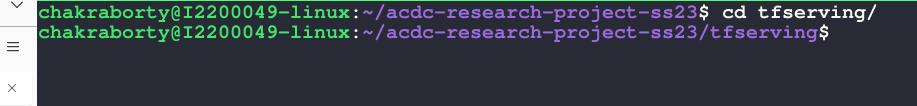

### **Install dependencies**

Let's install the dependencies required for the TFServing

```bash
pip install -r requirements.txt
```

### **Download ROS Bag file**

To test this, we have a sample ROSBag which we downloaded from the ACDC course github repo. Since the recent ACDC course has the ROSBag in the ROS2 Version, we have given the command below which pulls it in from our google drive. Just run this inside the tfserving directory itself.

```bash
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1S0Yn6V2H34Z1dCYFrcPj5XPzZWcvkQFm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1S0Yn6V2H34Z1dCYFrcPj5XPzZWcvkQFm" -O left_camera_templergraben.bag && rm -rf /tmp/cookies.txt
```

![bagfile_dl.jpg](assets/tfserving/bagfile_dl.jpg)

## **Usage**

### **Docker Setup**

Next let us start the TFServing Docker. If you don't have the docker already setup, running the below code will automatically pull it. 

Also most importantly, make sure to have installed Docker (duh) and Nvidia Container Toolkit (if you want to use the GPU)

`docker run -p 8500:8500 -p 8501:8501 --mount type=bind,source=./model/mobilenetv3_large_os8_deeplabv3plus_72miou/,target=/models/mobilenet/1/ -e MODEL_NAME=mobilenet -t tensorflow/serving`

![docker.jpg](assets/tfserving/docker.jpg)

This command **runs a TensorFlow Serving container using Docker**, **binds ports 8500 & 8501**, and **serves a MobileNetV3 model** located at `./model/mobilenetv3_large_os8_deeplabv3plus_72miou/` with the **model name "mobilenet"**. 

The **port 8500** is typically used for serving models over **gRPC** (Google Remote Procedure Call), a high-performance, open-source, and universal RPC framework. 

On the other hand, **port 8501** is used for serving models via a **RESTful API**, enabling interactions using standard HTTP requests. 

By binding both these ports, the user is allowing the TensorFlow Serving container to serve models and accept requests over both gRPC and RESTful interfaces.

- #### Docker GPU configuration
If you want to run with GPU, run the below code,

```bash
docker run --gpus all -p 8500:8500 -p 8501:8501 --mount type=bind,source=./model/mobilenetv3_large_os8_deeplabv3plus_72miou/,target=/models/mobilenet/1/ -e MODEL_NAME=mobilenet -t tensorflow/serving:2.11.1-gpu
```

Note that we aren't using the 'latest' tensorflow serving GPU docker image, as it wasn't effectively working with our GPU. So we fell back to the previous version `tensorflow/serving:2.11.1-gpu`. This version works fine with the IKA Workstation.

You can view the GPU use, using `nvidia-smi` in another terminal

If you would like to use other models, just replace the `source` with your model path. 
You can also change the `target` name (just make sure to have the model name end with a /1/ as it is required for Vision based Neural Nets) and the `MODEL_NAME` variables.

### **Inference Script**

Run the script to start making inference requests to the TF Serving Inference Server.

```bash
python inferencer.py
```

![output_terminal.jpg](assets/tfserving/output_terminal.jpg)

## **Methodology**

We will now dive into the `inferencer.py` python script and explain its main component functions and logic flow.

This script, essentially:
- reads images from a ROSBag file, 
- preprocesses these images, 
- sends them to the server for inference, and then 
- processes the results, all while measuring the time taken for each step. 
    
This code will also output an image file named 'output.png' inside the tfserving directory itself (you can view it using jupyterlab itself, on the left panel)

Now, let's explore in detail the functions that are used in this script.

#### **Program Structure**

Below is a concise and redacted copy of the python `inferencer.py` program, to familiarize and get an overview of the different functions before we discuss each of them in detail subsequently

```python
...

# Vision Library
from img_utils import resize_image
import cv2
import tensorflow as tf

# ROSBag reader
from rosbags.rosbag1 import Reader
from rosbags.serde import deserialize_cdr, ros1_to_cdr

# Google Remote Procedure Call
import grpc
from tensorflow_serving.apis import predict_pb2, prediction_service_pb2_grpc

...

def segmentation_map_to_rgb(segmentation_map,color_palette):
    """
    Converts segmentation map to a RGB encoding according to self.color_palette
    Eg. 0 (Class 0) -> Pixel value [128, 64, 128] which is on index 0 of self.color_palette
        1 (Class 1) -> Pixel value [244, 35, 232] which is on index 1 of self.color_palette

    self.color_palette has shape [256, 3]. Each index of the first dimension is associated
    with an RGB value. The index corresponds to the class ID.

    :param segmentation_map: ndarray numpy with shape (height, width)
    :return: RGB encoding with shape (height, width, 3)
    """
    rgb_encoding = color_palette[segmentation_map]
    return rgb_encoding

def parse_convert_xml(conversion_file_path):
    """
    Parse XML conversion file and compute color_palette 
    """

    defRoot = ET.parse(conversion_file_path).getroot()
    
    ...

    return color_palette, class_names, color_to_label

def predict_rest(json_data, url,color_palette):
    """
    Make predictions using a remote machine learning model served through a REST API.

    Parameters:
    - json_data: JSON-formatted data containing input for the model.
    - url: The URL endpoint of the TensorFlow Serving server hosting the model.
    - color_palette: A color palette used for post-processing the model's predictions.
    """
    
    ... 
    
    return prediction, prediction_time,postprocessing_time

def predict_grpc(data, input_name, stub,color_palette):
    """
    Make predictions using gRPC for a machine learning model served by TensorFlow Serving.

    Parameters:
    - data: Input data for prediction.
    - input_name: The name of the input tensor in the model.
   """
    
    ...
    
    return prediction, preprocessing_time,prediction_time,postprocessing_time


def bag_reader(bag_file,flag,color_palette):

    '''
    Reads frames from a ROSBag file and processes them using OpenCV and TensorFlow Serving based on the specified flag.

    Args:
        bag_file (str): The path to the ROSBag file containing camera frames.
        flag (str): A flag indicating whether to use TensorFlow Serving ('grpc') or a REST API ('rest') for inference.
    '''

    while True: # Useful to loop the ROSBag as there ain't existing built-in func
        image_retrieve_list, image_preprocess_list, request_preprocess_list, prediction_list,postprocessing_list = [],[],[],[],[]

        ...
        
                        print("Average Postprocessing Time: ",avg_postprocess)
                        break
                    
                    
def serving_func(input_img,flag,color_palette):
    '''
    Processes an input image using gRPC or a REST API based on the specified flag and performs various measurements.

    Args:
        input_img (numpy.ndarray): The input image for inference.
        flag (str): A flag indicating whether to use gRPC ('grpc') or a REST API ('rest') for inference.
    '''
    
    ...

    return image_preprocess,request_preprocess,prediction_time,postprocessing_time


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Specify trigger and model_export_path.')
    parser.add_argument('--bag', type=str, default='left_camera_templergraben.bag', help='Path to the Bag file')
    parser.add_argument('--model_export_path', type=str, default='./model/mobilenetv3_large_os8_deeplabv3plus_72miou/', 
                        help='Path to the model export directory. Make sure the model path matches the one TFServing is serving :)')
    parser.add_argument('--trigger', type=str, default='grpc', help='Trigger for mode (e.g., "grpc" or "rest").')
   
    ...
    
    color_palette, class_names, color_to_label = parse_convert_xml(path_to_xml)
    bag_reader(bag_file=args.bag,flag=args.trigger,color_palette=color_palette)
    
    
```

#### **Main Entrypoint Function**

```python
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Specify trigger and model_export_path.')
    parser.add_argument('--bag', type=str, default='left_camera_templergraben.bag', help='Path to the Bag file')
    parser.add_argument('--model_export_path', type=str, default='./model/mobilenetv3_large_os8_deeplabv3plus_72miou/', 
                        help='Path to the model export directory. Make sure the model path matches the one TFServing is serving :)')
    parser.add_argument('--trigger', type=str, default='grpc', help='Trigger for mode (e.g., "grpc" or "rest").')
    args = parser.parse_args()
    print("Running the Model present in the path ",args.model_export_path)
    
    if args.trigger != 'rest': # Anything other than REST API, will trigger the gRPC
        print("Running gRPC mode")
        #gRPC Setting up 
        channel_opt = [('grpc.max_send_message_length', 512 * 1024 * 1024), ('grpc.max_receive_message_length', 512 * 1024 * 1024)]
        channel = grpc.insecure_channel("0.0.0.0:8500", options=channel_opt) #Change this if using any other system other LocalHost for Cloud
        stub = prediction_service_pb2_grpc.PredictionServiceStub(channel) # Used to send the gRPC request to the TF Server

        # Get the serving_input key

        model_export_path = args.model_export_path
        loaded_model = tf.saved_model.load(model_export_path)
        input_name = list(
            loaded_model.signatures["serving_default"].structured_input_signature[1].keys()
        )[0]
    else:
        print("Running REST API mode")

    # Bag file 
    path_to_xml = 'xml/cityscapes.xml'

    #path_to_xml = 'convert.xml'
    color_palette, class_names, color_to_label = parse_convert_xml(path_to_xml)
    bag_reader(bag_file=args.bag,flag=args.trigger,color_palette=color_palette)
```

- An **argument parser** is set up using Python's argparse library, which is commonly used to make command-line interfaces.
    - *Arguments:*
        - **--bag**: Path to a bag file (default is `left_camera_templergraben.bag`).
        - **--model_export_path**: Path to the exported model directory (default is `./model/mobilenetv3_large_os8_deeplabv3plus_72miou/`).
        - **--trigger**: Specifies the mode in which the script should run; either `gRPC` (default) or `REST API`.

    The user can provide these arguments when running the script.
    
- **gRPC Setup**:
    - If the trigger argument is not 'rest', the script will set up a gRPC client:
    - It defines channel options to specify the maximum send and receive message length (both set to 512MB in this case).
    - It creates a gRPC channel to communicate with a server listening at 0.0.0.0:8500 (for the TensorFlow Serving running on the same machine on port 8500).
    - It then initializes a stub for the prediction service, which will be used to send gRPC requests to the TensorFlow server
    - It then loads the saved TensorFlow model. 
    - Then, it determines the input key name for the model signature. This key is important for correctly formatting the inference requests to TensorFlow Serving.


- **REST API Mode**:
    - If the --trigger argument was set to `rest`, the script will print "Running REST API mode", triggering the use of the REST API mode for communication. 

- **XML Label File parsing**
    - The script sets a path to an XML file. It then parses this XML file to get the `color palette`, `class names`, and `color to label` mapping (using the parse_convert_xml function).
    
- **ROS Bag File Processing**
    - Finally, it reads and processes the specified bag file using a function named `bag_reader`. Bag files are typically associated with the ROS (Robot Operating System) and store ROS topic data. In our case, we use it to simulate the Vehical Camera images. 
    - The script reads the bag file and process it based on the color palette obtained from the XML.

#### **PreProcessing: Parse and Convert XML**

```python
def parse_convert_xml(conversion_file_path):
    """
    Parse XML conversion file and compute color_palette 
    """

    defRoot = ET.parse(conversion_file_path).getroot()

    color_to_label = {}

    color_palette = np.zeros((256, 3), dtype=np.uint8)
    class_list = np.ones((256), dtype=np.uint8) * 255
    class_names = np.array(["" for _ in range(256)], dtype='<U25')
    for idx, defElement in enumerate(defRoot.findall("SLabel")):
        from_color = np.fromstring(defElement.get("fromColour"), dtype=int, sep=" ")
        to_class = np.fromstring(defElement.get("toValue"), dtype=int, sep=" ")
        class_name = defElement.get('Name').lower()
        if to_class in class_list:
            color_to_label[tuple(from_color)] = int(to_class)
        else:
            color_palette[idx] = from_color
            class_list[idx] = to_class
            class_names[idx] = class_name
            color_to_label[tuple(from_color)] = int(to_class)

    # Sort classes accoring to is train ID
    sort_indexes = np.argsort(class_list)

    class_list = class_list[sort_indexes]
    class_names = class_names[sort_indexes]
    color_palette = color_palette[sort_indexes]

    return color_palette, class_names, color_to_label

```

- The function `parse_convert_xml` is designed to parse an XML file that contains information about various semantic labels (or classes) and their associated colors. Let's break it down step by step. 
- This function parses an XML file to extract label information and color mappings. The XML file is expected to have a specific format with elements named "SLabel" and attributes such as "fromColour", "toValue", and "Name".

- Parameters:
    - **conversion_file_path**: The file path to the XML conversion file that will be parsed.

- Inner Functions:
    - defRoot: This variable is an instance of the root element of the XML file after parsing it. It represents the top-level element in the XML structure.

- Variables Initialization:

    - *color_to_label*: A dictionary that will map RGB color values (as tuples) to class IDs.

    - *color_palette*: A numpy array of shape (256, 3) initialized with zeros. This array will store RGB values for each class.

    - *class_list*: A numpy array of shape (256) initialized with values of 255. This array will store class IDs.

    - *class_names*: A numpy array of shape (256) with string type initialized with empty strings. This will store the names of each class.

- Looping Through XML Elements, for each SLabel element in the XML file, we are,

    - Extracting Attributes:
        - from_color: The RGB values associated with this label. Extracted from the "fromColour" attribute and split into a numpy array.
        - to_class: The class ID. Extracted from the "toValue" attribute and converted to an integer.
        - class_name: The name of the class. Extracted from the 'Name' attribute and converted to lowercase.

    - Populating Data Structures:
        - If to_class is already in class_list, then simply map the RGB color to this class in color_to_label.
        - Otherwise, store the extracted RGB values, class IDs, and class names in their respective arrays (color_palette, class_list, and class_names). Also, add the color-to-label mapping in the color_to_label dictionary.

- Sorting:

    After parsing all the SLabel elements, the function sorts the arrays based on the class IDs to ensure a consistent order.

    - sort_indexes: Compute the indexes that would sort class_list.
    - Reorder the class_list, class_names, and color_palette arrays based on the computed sort indexes.


- Return/Output:

    The function returns three pieces of information:

    - **color_palette**: The sorted RGB values for each class.
    - **class_names**: The sorted names of each class.
    - **color_to_label**: A dictionary mapping RGB colors to class IDs based on the XML file.


- The `parse_convert_xml` function extracts and organizes semantic label information (like class names and their associated RGB colors) from a given XML file. It provides a color palette, class names, and a mapping between colors and class IDs.

#### **Bag Reader**

```python
def bag_reader(bag_file,flag,color_palette):

    '''
    Reads frames from a ROSBag file and processes them using OpenCV and TensorFlow Serving based on the specified flag.

    Args:
        bag_file (str): The path to the ROSBag file containing camera frames.
        flag (str): A flag indicating whether to use TensorFlow Serving ('grpc') or a REST API ('rest') for inference.
    '''

    while True: # Useful to loop the ROSBag as there ain't existing built-in func
        image_retrieve_list, image_preprocess_list, request_preprocess_list, prediction_list,postprocessing_list = [],[],[],[],[]

        with Reader(bag_file) as reader:
        # Iterate over messages
            for connection, timestamp, rawdata in reader.messages():
                if connection.topic == '/sensors/camera/left/image_raw':
                    # Assuming 'sensor_msgs/Image' message type
                    image_retrieval_start = time.time()
                    msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)
                    
                    # Convert ROS image data to OpenCV image
                    img_data = msg.data
                    width = msg.width
                    height = msg.height
                    encoding = msg.encoding
                    np_arr = np.frombuffer(img_data, np.uint8)
                    reshaped_array = np_arr.reshape((height, width))  # Assuming 3 channels (BGR in OpenCV)
                    reshaped_array = ((reshaped_array - reshaped_array.min()) / (reshaped_array.max() - reshaped_array.min()) * 255).astype(np.uint8)
                    demosaiced_image = cv2.cvtColor(reshaped_array, cv2.COLOR_BAYER_RG2BGR) # Required to convert BAYER format to BGR
                    rgb_image = cv2.cvtColor(demosaiced_image, cv2.COLOR_BGR2RGB) #BGR to RGB
                    image_retrieval_end = time.time()
                    image_retrieve = image_retrieval_end - image_retrieval_start # Time it takes for one frame from the ROSBag
                    
                    image_preprocess,request_preprocess,prediction_time,postprocessing_time = serving_func(rgb_image,flag,color_palette)
                    
                    image_retrieve_list.append(image_retrieve)
                    image_preprocess_list.append(image_preprocess)
                    request_preprocess_list.append(request_preprocess)
                    prediction_list.append(prediction_time)
                    postprocessing_list.append(postprocessing_time)

                    if (len(prediction_list)>5):
                        image_retrieve_list.pop(0)
                        image_preprocess_list.pop(0)
                        request_preprocess_list.pop(0)
                        prediction_list.pop(0)
                        postprocessing_list.pop(0)
                        number = len(image_retrieve_list)
                        # Average over the last 5 values
                        avg_image_retrieve = sum(image_retrieve_list)/number
                        avg_image_preprocess = sum(image_preprocess_list)/number
                        avg_request_preprocess = sum(request_preprocess_list)/number
                        avg_prediction = sum(prediction_list)/number
                        avg_postprocess = sum(postprocessing_list)/number
                        print("Average Image Retrieval: ", avg_image_retrieve, "Average Image Preprocessing: ", avg_image_preprocess)
                        print("\n")
                        print("Average Request Preprocessing: ",avg_request_preprocess, "Average Prediction Time: ", avg_prediction)
                        print("\n")
                        print("Average Postprocessing Time: ", avg_postprocess)
                        break
```                    

The function, `bag_reader(bag_file, flag, color_palette)`, reads the frames from a ROSBag file. The frames are then processed using OpenCV and an inference method either via TensorFlow Serving ('grpc') or a REST API ('rest') based on the specified flag.

- **Input arguments**:
    
    - **bag_file** *(str)*: Path to the ROSBag file containing camera frames.
    - **flag** *(str)*: A flag indicating the method of inference. If it's 'grpc', the function uses TensorFlow Serving. If it's 'rest', a REST API is used.
    - **color_palette**: The color_palette from the XML label file.


- **Execution Flow**:
    
    - Initialization: An infinite loop (while True) is started. This loop allows for continuous processing of the ROSBag.
    - Reading the ROSBag:
        - The bag file is read using a context manager with Reader(bag_file) as reader:.
        - The code then iterates over each message in the ROSBag.
    - Filtering Messages:
        - The code looks for messages with the topic `/sensors/camera/left/image_raw`, which contains the image data from a camera.
    - Image Retrieval and Conversion:
        - The raw data of the message is deserialized and converted to a more readable format.
        - The image data is extracted from the ROS message and converted to a format usable by OpenCV.
        - The image data is then demosaiced (converted from the Bayer format to RGB). This is essential as many cameras capture data in the Bayer format, which is a patterned arrangement of color filters.
    - Image Processing:
        - The image is then processed by the serving_func. This function probably uses TensorFlow Serving or a REST API to get some predictions or process the image further. The timings for various steps in the serving_func are returned.
    - Sliding Window of Timings:
        - The timing metrics are appended to the lists.
        - If more than 5 metrics exist in the lists, the oldest (first) metric is removed. This maintains a "sliding window" of the last 5 timing metrics.
        - The average of these timing metrics is then computed and displayed. This provides a moving average of the timings for the last 5 frames.
    - Exit Condition:
        - After processing and printing the average timings for 5 frames, the infinite loop is broken with the break statement.

- In summary, this function reads frames from a ROSBag file, processes them using OpenCV, sends them for further processing or prediction using either TensorFlow Serving or a REST API (based on the provided flag), measures the time taken for each step, and then prints the average timing metrics for the last 5 frames

#### **Serving Function**

```python                    
def serving_func(input_img, flag, color_palette):
    '''
    Processes an input image using gRPC or a REST API based on the specified flag and performs various measurements.

    Args:
        input_img (numpy.ndarray): The input image for inference.
        flag (str): A flag indicating whether to use gRPC ('grpc') or a REST API ('rest') for inference.
    '''
    
    # input image dimensions
    width = 2048
    height = 1024
    
    # preprocessing
    preprocess_start = time.time()
    input_img = resize_image(input_img,[height,width])
    input_img = input_img / 255.0
    batched_img = np.expand_dims(input_img, axis=0)
    batched_img = batched_img.astype(float)
    print(f"Batched image shape: {batched_img.shape}")
    preprocess_end = time.time()
    
    # preprocessing time calculation 
    image_preprocess = preprocess_end - preprocess_start
    
    REST_request_preprocess = "None"

    if flag == 'rest':
        ### Serving part 
        rest_start = time.time()
        data = json.dumps(
            {"signature_name": "serving_default", "instances": batched_img.tolist()}
        )
        rest_end = time.time()

        # Docker command for setting up Server :
        '''
        CHECK README
        '''
        url = "http://localhost:8501/v1/models/mobilenet:predict" #If tfserving on your local system
        #url = "http://i2200049.ika.rwth-aachen.de:8501/v1/models/mobilenet:predict" # If tfserving on the IKA Workstation NEEDS DEBUGGING

    if flag == 'rest':
        prediction,prediction_time,postprocessing_time = predict_rest(data, url,color_palette)
        request_preprocess = rest_end-rest_start
    else:
        prediction,request_preprocess,prediction_time,postprocessing_time = predict_grpc(batched_img,input_name=input_name,stub=stub,color_palette=color_palette)
    
    prediction = cv2.cvtColor(prediction,cv2.COLOR_BGR2RGB)
    cv2.imwrite('output.png',prediction)

    return image_preprocess, request_preprocess, prediction_time, postprocessing_time

```

- This is the TF Serving prediction wrapper function for the gRPC and REST api inference functions ``

- Inputs:

    - input_img (numpy.ndarray): The input image for inference.
    - flag (str): A flag indicating the method of inference. If it's 'grpc', the function uses gRPC for communication. If it's 'rest', a REST API is used.
    - color_palette: An input parameter likely used in subsequent functions (predict_rest and predict_grpc) for some kind of image processing or visualization, but its exact use isn't defined in the provided snippet.


- Overview
    - Input Image dimensions initialization:
        - The dimensions of the desired image size are set as width = 2048 and height = 1024.

    - Preprocessing:
        - The time before preprocessing starts is recorded.
        - The input image is resized to the specified dimensions.
        - The pixel values of the image are normalized to the range [0,1] by dividing them by 255.0.
        - The image is batched (an additional dimension is added) to prepare it for inference, and its data type is set to float.
        - The shape of the batched image is printed.
        - The time after preprocessing ends is recorded.

    - Request Preprocessing for REST:
        - If the flag is set to 'rest', the batched image data is serialized into JSON format in preparation for a REST API call. This includes specifying the model's signature name and the instances for prediction. This serialization time is recorded.

    - Server URL Initialization:
        - A URL is provided for sending the image data for inference. 
        - Two URLs are provided in the code, one for a local TensorFlow Serving setup and another for the IKA workstation (commented out)

    - Inference:
        - If the flag is 'rest', the data is sent to the REST endpoint for prediction using the **predict_rest** function, and the request preprocessing time for REST is calculated.
        - Otherwise (if the flag is not 'rest'), the **predict_grpc** function is used to send the image data for prediction using gRPC. The necessary parameters like input_name and stub are provided, although their values are not defined in the snippet.

    - Post-Processing:
        - The predicted image is converted from BGR to RGB format.
        - The result is also saved as an output image output.png, for quick testing and reference.

- In summary, the **serving_func** function preprocesses the input image, prepares it for inference, sends it to a server for prediction (either using a REST API or gRPC based on the provided trigger flag), and saves the resulting image. It also measures and returns the time taken for various stages of this process.

#### **REST API Prediction function**

```python
def predict_rest(json_data, url, color_palette):
    """
    Make predictions using a remote machine learning model served through a REST API.

    Parameters:
    - json_data: JSON-formatted data containing input for the model.
    - url: The URL endpoint of the TensorFlow Serving server hosting the model.
    - color_palette: A color palette used for post-processing the model's predictions.

    Returns:
    - prediction: The processed prediction result, typically an image or classification output.

    Description:
    This function sends a JSON-formatted input to a remote TensorFlow Serving server specified by the 'url'.
    The server processes the input using the hosted model and returns a prediction response in JSON format.
    The prediction response is then post-processed to obtain the final prediction, often an image or classification result,
    which is returned as the output of this function.

    Note:
    - The function assumes that the TensorFlow Serving server is correctly set up to handle REST API requests.
    - The 'color_palette' parameter is used for converting the model's segmentation map into a colored image.

    Models Available:
    -  best_weights_e=00231_val_loss=0.1518
    -  mobilenetv3_large_os8_deeplabv3plus_72miou

    Example Usage:
    - prediction = predict_rest(json_input, "http://example.com/model_endpoint", color_palette)
    """
    prediction_start = time.time()
    json_response = requests.post(url, data=json_data)
    response = json.loads(json_response.text)
    prediction_end = time.time()
    prediction_time = time.time()-prediction_start

    predictions = np.array(response["predictions"])

    prediction = np.squeeze(predictions).tolist()  # Convert to list
    argmax_prediction = np.argmax(prediction, axis=2)
    prediction = segmentation_map_to_rgb(argmax_prediction,color_palette=color_palette).astype(np.uint8)
    postprocessing_time = time.time() - prediction_end
    
    return prediction, prediction_time,postprocessing_time
```

- This function sends the input data in JSON format to a remote TensorFlow Serving server and retrieves the model's predictions in JSON format. 
- The received prediction is then post-processed to get the final result, which is typically an image or classification output.
- In essence, the `predict_rest` function sends input data to a TensorFlow Serving server for inference, receives raw predictions, post-processes those predictions, especially for segmentation tasks, and returns the post-processed results along with timing metrics for inference and post-processing.

- Inputs:

    - **json_data**: A string containing JSON-formatted data that represents the input for the model.
    - **url**: The endpoint URL of the TensorFlow Serving server hosting the model.
    - **color_palette**: A palette used for post-processing the model's predictions, especially useful for segmentation tasks.

- Outputs:

    - **prediction**: The processed prediction result.
    - **prediction_time**: The time taken for receiving the prediction from the server.
    - **postprocessing_time**: The time taken to post-process the raw prediction received from the server.


- Overview:
    - Start Prediction Timer:
        - The current time is recorded to measure the time taken to get a prediction from the server.

    - Request Prediction:
        - The JSON-formatted input data (json_data) is sent to the specified server URL (url) using an HTTP POST request.
        - The TFServing server's response, assumed to be in JSON format, is parsed to get the prediction result.

    - Calculate Prediction Time:
        - The time taken for the server to return a prediction is calculated by finding the difference between the current time and the time recorded before sending the request.

    - Post-process Prediction:
        - The raw predictions are extracted from the server's response.
        - Since the predictions may represent the likelihood for each class, the class with the maximum likelihood is determined using the np.argmax function. This is especially relevant for segmentation tasks.
        - The prediction, which represents class labels (after using np.argmax), is then converted to an RGB image using the segmentation_map_to_rgb function and the provided color_palette.

    - Calculate Post-processing Time:
        - The time taken to post-process the raw predictions is calculated.

    - Return Values:
        - The function returns the post-processed prediction, along with the time taken for prediction (prediction_time) and post-processing (postprocessing_time).

#### **gRPC Prediction function**

```python
def predict_grpc(data, input_name, stub,color_palette):
    """
    Make predictions using gRPC for a machine learning model served by TensorFlow Serving.

    Parameters:
    - data: Input data for prediction.
    - input_name: The name of the input tensor in the model.
    - stub: gRPC stub for communicating with the TensorFlow Serving server.
    - color_palette: A color palette used for post-processing the prediction.

    Returns:
    - prediction: The processed prediction result.

    Description:
    This function sends input data to a TensorFlow Serving server using gRPC for model prediction.
    It assumes the server is hosting a semantic segmentation model.
    The function processes the gRPC response, converts it to an image format, and applies color mapping using the provided color_palette.
    """
    grpc_request_preprocess = time.time()

    # Create a gRPC request made for prediction
    request = predict_pb2.PredictRequest()

    # Set the name of the model, for this use case it is "model"
    request.model_spec.name = "mobilenet" # Based on the Tensorflow Docker command, under the MODEL_NAME

    # Set which signature is used to format the gRPC query
    # here the default one "serving_default"
    request.model_spec.signature_name = "serving_default"

    # Set the input as the data
    # tf.make_tensor_proto turns a TensorFlow tensor into a Protobuf tensor
    request.inputs[input_name].CopyFrom(tf.make_tensor_proto(data.tolist()))
    preprocess_end = time.time()
    preprocessing_time = preprocess_end - grpc_request_preprocess
    # Send the gRPC request to the TF Server
    result = stub.Predict(request)
    prediction_end = time.time()
    prediction_time = prediction_end-preprocess_end
    # Process the gRPC response
    output_name = list(result.outputs.keys())[0]
    output_data = result.outputs[output_name].float_val  # Assuming the output is in float format

    # Convert the float data to an image format
    output_data = np.array(output_data)
    height = 1024
    width = 2048
    num_channels = 20
    output_data = output_data.reshape((1, height, width, num_channels))  # Adjust the shape accordingly
    #output_data = (output_data * 255).astype(np.uint8)  # Assuming output is in the range [0, 1]

    # Convert the image to RGB

    argmax_prediction = np.argmax(output_data, axis=3)
    prediction = segmentation_map_to_rgb(argmax_prediction, color_palette=color_palette).astype(np.uint8)
    prediction = np.squeeze(prediction)
    postprocessing_time = time.time() - prediction_end
    return prediction, preprocessing_time, prediction_time, postprocessing_time
```

- The `predict_grpc` function is designed to make predictions using a TensorFlow model served through gRPC (Google Remote Procedure Call). 

- Arguments/ Parameters:

    - **data**: The input Image data for prediction
    - **input_name**: The name of the input tensor placeholder in the TensorFlow model.
    - **stub**: An instance of a gRPC client stub, which enables the client to call methods on a remote server application on a different machine.
    - **color_palette**: A palette used for post-processing the model's predictions, especially relevant for segmentation tasks where each segment/class needs a unique color.

- Overview:

    - Start Request Preprocessing Timer:
        - The current time is captured to eventually measure the time taken for preparing the gRPC request.
        
    - Prepare gRPC Request:
        - A **PredictRequest** object is created. This object will encapsulate the details of the prediction request to be sent to the TensorFlow Serving server.
        - The name of the model ("mobilenet") and the signature name ("serving_default") are set. The model name typically corresponds to the name of the model when it was deployed using TensorFlow Serving.
        - The input tensor is converted to a Protobuf format and added to the request using the specified input_name.
        
    - End Request Preprocessing Timer & Calculate Preprocessing Time:
        - The current time is captured again and subtracted from the initial time to calculate the preprocessing time.

    - Send gRPC Request & Receive Response:
        - The gRPC request is sent to the TensorFlow Serving server using the provided stub.
        - The result received from the server is stored in the result variable.

    - Calculate Prediction Time:
        - The time taken by the server to process the request and return the prediction is computed.

    - Process Server Response:
        - The name of the output tensor is extracted from the result.
        - The raw prediction data is retrieved from the result and assumed to be in float format.
        - This raw prediction data is reshaped into an appropriate shape representing images with height, width, and the number of channels/classes. The shape is set as (1, height, width, num_channels).

    - Post-process Predictions:
        - The raw predictions represent likelihood scores for each class (in the case of semantic segmentation). The class with the highest likelihood is determined using the np.argmax function.
        - Using the provided color_palette, the class labels are then converted to an RGB image through the segmentation_map_to_rgb function.
        - The RGB image is further squeezed to remove singleton dimensions.

    - Calculate Post-processing Time:
        - The time taken to post-process the raw predictions is computed.

    - Return Results:
        - The post-processed prediction, preprocessing time, prediction time, and post-processing time are returned.

- The **predict_grpc** function prepares and sends a gRPC request to the TensorFlow Serving server for model prediction. Upon receiving the prediction response, the function post-processes the predictions to convert them into an interpretable format (like a colored segmentation map) and returns the processed predictions along with various timing metrics.

#### **PostProcessing: Segmentation Map to RGB**

```python
def segmentation_map_to_rgb(segmentation_map, color_palette):
    """
    Converts segmentation map to a RGB encoding according to self.color_palette
    Eg. 0 (Class 0) -> Pixel value [128, 64, 128] which is on index 0 of self.color_palette
        1 (Class 1) -> Pixel value [244, 35, 232] which is on index 1 of self.color_palette

    self.color_palette has shape [256, 3]. Each index of the first dimension is associated
    with an RGB value. The index corresponds to the class ID.

    :param segmentation_map: ndarray numpy with shape (height, width)
    :return: RGB encoding with shape (height, width, 3)
    """
    rgb_encoding = color_palette[segmentation_map]
    return rgb_encoding
```

- The `segmentation_map_to_rgb` function's purpose is to transform a semantic segmentation map, which contains class IDs, into an RGB image where each class ID is replaced with its corresponding color from the given color palette.

- Arguments/ Parameters:
    - **segmentation_map**: A 2D numpy array of shape (height, width). This array represents the segmentation result, where each value corresponds to a class ID.

    - **color_palette**: A 2D numpy array of shape (256, 3). This is essentially a lookup table, where each row index corresponds to a class ID and each row contains the RGB color representation for that class ID.

- Indexing with color_palette:
    - The main operation here is `color_palette[segmentation_map]`
    - The segmentation_map contains class IDs which are used to index into color_palette. This means that for each class ID in segmentation_map, numpy will fetch the RGB color from color_palette.


Below is the output image from the TFServing inference, for reference.  (an `image.png` image file was used to save the segmented image prediction for displaying it in the jupyter notebook )

![output_setup.jpg](assets/tfserving/output_setup.jpg)

# **MQTT Based Inference**

## **Setup/ Dependencies**

### **MQTT Broker**

#### **MQTT Broker Encryption Setup**

Below is a concise guide, meant as a quick reference for commands to run for setting up the  Public-Key Infrastructure using OpenSSL, to allow for encrypted communication between the MQTT Broker and clients.

We highly recommend following the guide created by the folks at [IKA, Institut für Kraftfahrzeuge, RWTH Aachen](https://github.com/ika-rwth-aachen) for their [mqtt-in-docker](https://github.com/ika-rwth-aachen/mqtt-in-docker) repository, referred [here](https://github.com/ika-rwth-aachen/mqtt-in-docker#encrypted-communication), for exact and more in depth details, and keeping it open as a reference while following these steps. 

Note that we are only setting up the Encrypted MQTT Communnication connections secured through SSL/TLS using a public key infrastructure (PKI). For also setting up Authenticated Communication, refer [here](https://github.com/ika-rwth-aachen/mqtt-in-docker#authenticated-communication)

Keys/Ceritificates that need to be created.

1. **Certificate-Authority private key** (*ca-key.pem*)
2. **Certificate-Authority certificate** (*ca-cert.pem*)
3. **Server (Broker) private key** (*server-key.pem*)
4. self-signed **Server (Broker) certificate** (*server-cert.pem*)
5. **Client private key** (*client-key.pem*) 
6. self-signed **Client certificate** (*client-cert.pem*)

##### **Directory Structure**

```
mosquitto_broker
├── encryption                      # files for the Public-Key Infrastructure
|   ├── certificate-authority       # certs, keys & csr for CA
│   │   ├── ca-cert.pem
│   │   ├── ca-cert.srl
│   │   ├── ca-csr.pem
│   │   └── ca-key.pem
|   ├── client                      # certs, keys & csr for clients
│   │   ├── client-cert.pem
│   │   ├── client-csr.pem
│   │   └── client-key.pem
|   └── server                      # certs, keys & csr for server
│       ├── server-cert.pem
│       ├── server-csr.pem
│       └── server-key.pem
├── configs                         # where Mosquitto configuration files can be stored
│   ├── mosquitto.ssl-all.conf
│   └── mosquitto.ssl-server.conf
└── run_broker_encrypted.sh
```

##### **Initial Setup**

Open a new terminal and move into the cloned /acdc-research-project-ss23 directory. 
Then, move to the mqtt/mosquitto_broker directory.
```bash
cd mqtt/mosquitto_broker
```

If not already created, create the directories holding the encryption keys and certificates required for encrypted MQTT communication.
```
mkdir -p encryption/certificate-authority encryption/server encryption/client
```

*NOTE*: 

Alternatively, you may clone the [mqtt-in-docker](https://github.com/ika-rwth-aachen/mqtt-in-docker) repository from where these instructions are taken.

Here, for brevity, we have created this quick setup for our package, following the same directory structure and verbatim commands from the [IKA MQTT Encryption Setup](https://github.com/ika-rwth-aachen/mqtt-in-docker#encrypted-communication).

##### **Certificate Authority**

We need a self-signed root certificate of a root Certificate Authority (CA) and a corresponding private key.

1. First, start by creating the **Certificate Authority private key** (*ca-key.pem*) and a **Certificate Authority certificate signing request** (*ca-csr.pem*). 
    ```bash
    openssl req -newkey rsa:2048 -nodes -keyout encryption/certificate-authority/ca-key.pem -out encryption/certificate-authority/ca-csr.pem
    ```
    **NOTE:** All fields *may* be filled with the default value (press Enter), **Common Name** must be left empty. For the **Organization Name**, you may choose 'ca'

2. Next, create the root **Certificate Authority certificate** (*ca-cert.pem*)
    ```bash
    openssl x509 -req -in encryption/certificate-authority/ca-csr.pem -signkey encryption/certificate-authority/ca-key.pem -out encryption/certificate-authority/ca-cert.pem -days 365 -sha256
    ```
 

##### **Server (with Broker)**

Create a **Server Private Key** (server-key.pem) and a **self-signed Cerver Certificate** (server-cert.pem).

1. Create the **server certificate signing request** (*server-csr.pem*) and the **server private key** (*server-key.pem*). 

    ```bash
    openssl req -newkey rsa:2048 -nodes -keyout encryption/server/server-key.pem -out encryption/server/server-csr.pem
    ```
    For the Organization Name, choose `server`. All other fields can be filled with the default value (press Enter).

    When asked for the Common Name, enter `localhost`. 

    **Multi-Machine Setup**: If you want to test the encrypted setup across multiple machines, you should not use `localhost` for the Common Name but the Host + Domain Name, or IP of the machine running the broker. For eg., for the IKA workstation we may use `i2200049.ika.rwth-aachen.de`

2. Now, create the self-signed **server certificate** (`server-cert.pem`)
server-cert.pem
    ```bash
    openssl x509 -req -days 365 -in encryption/server/server-csr.pem -CA encryption/certificate-authority/ca-cert.pem -CAkey encryption/certificate-authority/ca-key.pem -CAcreateserial -out encryption/server/server-cert.pem
    ```


##### **Client** 

We can set up the broker such that it requires clients connecting to it to possess a **client certificate** (*client-cert.pem*) signed by the CA, and a **client private key** (*client-key.pem*) as well. The process for creating signed client certificates is the same as for the server. 

1. First, we create a **client private key** and a **client certificate signing request**. 

    ```bash
    openssl req -newkey rsa:2048 -nodes -keyout encryption/client/client-key.pem -out encryption/client/client-csr.pem
    ```

    For Organization Name, choose `client`.
    All other fields can be filled with the default value (press Enter).
    
    When asked for the Common Name, enter `localhost`. 

    **NOTE**: For **Multi-Machine Setup**: If you want to test the encrypted setup across multiple machines, you should not use `localhost` for the Common Name, but the Host + Domain Name, or the IP of the machine running the broker. For eg., for the IKA workstation running the broker, we may use `i2200049.ika.rwth-aachen.de` 

2. Finally, create the self-signed **client certificate** (`client-cert.pem`) 

    ```bash
    openssl x509 -req -days 365 -in encryption/client/client-csr.pem -CA encryption/certificate-authority/ca-cert.pem -CAkey encryption/certificate-authority/ca-key.pem -CAserial encryption/certificate-authority/ca-cert.srl -out encryption/client/client-cert.pem
    ```

##### **Commands Quick Reference**

Simply the above commands, without details, just commands.

- `cd mosquitto_broker/`

- `openssl req -newkey rsa:2048 -nodes -keyout encryption/certificate-authority/ca-key.pem -out encryption/certificate-authority/ca-csr.pem`

- `openssl x509 -req -in encryption/certificate-authority/ca-csr.pem -signkey encryption/certificate-authority/ca-key.pem -out encryption/certificate-authority/ca-cert.pem -days 365 -sha256`

- `openssl req -newkey rsa:2048 -nodes -keyout encryption/server/server-key.pem -out encryption/server/server-csr.pem`

- `openssl x509 -req -days 365 -in encryption/server/server-csr.pem -CA encryption/certificate-authority/ca-cert.pem -CAkey encryption/certificate-authority/ca-key.pem -CAcreateserial -out 
encryption/server/server-cert.pem`

- `openssl req -newkey rsa:2048 -nodes -keyout encryption/client/client-key.pem -out encryption/client/client-csr.pem`

- `openssl x509 -req -days 365 -in encryption/client/client-csr.pem -CA encryption/certificate-authority/ca-cert.pem -CAkey encryption/certificate-authority/ca-key.pem -CAserial encryption/certificate-authority/ca-cert.srl -out encryption/client/client-cert.pem`

#### **Run the Encrypted MQTT Broker**

For running the encrypted broker. it is possible to
- only require the server to be part of the PKI (`mosquitto.ssl-server.conf`), or
- require both server and client to be part of the PKI (`mosquitto.ssl-all.conf`) .

from within the `mqtt/mosquitto_broker` directory, run
```bash
source run_broker_encrypted.sh
```
This script simply runs the docker command, referenced below, with the config requiring both server and client to be part of the PKI (`mosquitto.ssl-all.conf`)
    
```bash
docker run \
    --rm \
    --network host \
    --name mosquitto-encrypted \
    -v $PWD/configs/mosquitto.ssl-all.conf:/mosquitto/config/mosquitto.conf:ro \
    -v $PWD/encryption/server:/mosquitto/encryption/server:ro \
    -v $PWD/encryption/certificate-authority:/mosquitto/encryption/certificate-authority:ro \
    --user "$(id -u):$(id -g)" \
    eclipse-mosquitto

```

To get only the server to be part of the PKI (`mosquitto.ssl-server.conf`), 
change the line `-v $PWD/configs/mosquitto.ssl-all.conf:/mosquitto/config/mosquitto.conf:ro` 
to `-v $PWD/configs/mosquitto.ssl-server.conf:/mosquitto/config/mosquitto.conf:ro` 
in *run_broker_encrypted.sh*


Below image is a reference screen grab, showing the expected terminal output when running the broker after correct setup.

![broker.jpg](assets/mqtt/broker.jpg)

### **Vehicle & Cloud Node Setup**

Steps for setting up the Vehicle and Cloud nodes are *mostly* similar as they use the same ROS package **`mqtt_node`** that we have developed, and create separate docker containers using the same **`rwthika/acdc:latest`** docker image.

#### **Clone repository & Setup Workspaces (First Time Setup)** 

Move to the `mqtt` directory after cloning:
    
```bash
cd acdc-research-project-ss23/mqtt
```

Run script to create workspaces for the vehicle and cloud node (Do this only when running for the first time, after setting up the encryption keys):
```bash
source setup_new_ros_ws
```

##### **Steps Overview**

> details of the "**setup_new_ros_ws.sh**" helper script

```bash
# New ROS Workspace directory name
WS_DIR=$PWD
WS_NAME="mqtt_nodes_ws"

# vehicle and cloud nodes
WS_PATH=$WS_DIR/$WS_NAME
WS_VEHICLE=$WS_PATH/vehicle_node_ws
WS_CLOUD=$WS_PATH/cloud_node_ws

# mqtt broker encrypted communication ssl 
SSL_CRED_DIR="mosquitto_broker"

echo "preparing ROS workspaces for the Vehicle and Cloud nodes ..."
echo ""

mkdir -p $WS_CLOUD/src
mkdir -p $WS_VEHICLE/src

echo "copying mqtt_node to newly created workspace folders for cloud node and vehicle node separately"
cp -r mqtt_node $WS_VEHICLE/src/
cp -r mqtt_node $WS_CLOUD/src/

echo "folders created: $WS_PATH"
ls -la $WS_PATH

```

This creates a folder that would hold the vehicle and cloud nodes' ROS workspaces, within the current working directory, in a folder named **"ws_mqtt_nodes"**. this can be set to any folder name by changing the value in the helper script in "WS_NAME" variable.

Then the "mqtt_node" folder, which is a ROS package, is copied to the 2 separate workspaces as they are going to be built separately from within the cloud and vehicle nodes' docker containers.

```bash
if [ ! -f ./bag/left_camera_templergraben.bag ]
then
    echo "File does not exist in bag/ directory, downloading Bag file from google drive"
    wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1S0Yn6V2H34Z1dCYFrcPj5XPzZWcvkQFm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1S0Yn6V2H34Z1dCYFrcPj5XPzZWcvkQFm" -O ./bag/left_camera_templergraben.bag && rm -rf /tmp/cookies.txt

fi

echo "copying bag file to vehicle node workspace..."
mkdir -p $WS_VEHICLE/src/mqtt_node/src/bag/
cp bag/left_camera_templergraben.bag $WS_VEHICLE/src/mqtt_node/src/bag/

```
- **NOTE**: the bag file we are using "left_camera_templergraben.bag" has to be copied manually into the bag folder within the cloned repository root directory first. The above part of the script handles the automatic download from the Drive link, if the `bag/left_camera_templergraben.bag` does not exist. This script then copies the bag file to the vehicle node's workspace.

```bash
echo ""
echo "Copying the created mqtt encryption keys and certfiles..."

mkdir -p $WS_VEHICLE/src/mqtt_node/src/cert/client
cp -r $SSL_CRED_DIR/encryption/client $WS_VEHICLE/src/mqtt_node/src/cert/
cp -r $SSL_CRED_DIR/encryption/certificate-authority $WS_VEHICLE/src/mqtt_node/src/cert/

mkdir -p $WS_CLOUD/src/mqtt_node/src/cert/server
cp -r $SSL_CRED_DIR/encryption/server $WS_CLOUD/src/mqtt_node/src/cert/
cp $SSL_CRED_DIR/encryption/certificate-authority/ca-cert.pem $WS_CLOUD/src/mqtt_node/src/cert/

echo "copied MQTT Client certificates/keys to ros package at path: $WS_VEHICLE/src/mqtt_node/src/cert/ & $WS_CLOUD/src/mqtt_node/src/cert/ "

echo ""
echo "folder: $WS_VEHICLE/src/mqtt_node/src/cert/"
ls -la $WS_VEHICLE/src/mqtt_node/src/cert/
echo "folder: $WS_CLOUD/src/mqtt_node/src/cert/"
ls -la $WS_CLOUD/src/mqtt_node/src/cert/

```

This sets up the keys and certificates required for establishing encrypted connection with the Broker (when it is setup with SSL/TLS)


#### **Start Cloud Node Docker**

##### **Start Docker Container**
In a new terminal, here, we are using the run.sh docker helper shell script that was taken from the IKA ACDC gitlab repository, [here](https://github.com/ika-rwth-aachen/acdc/tree/main/docker/run.sh), and using the `rwthika/acdc:latest` docker image.

```bash
./docker/run.sh -n cloud_node -a
```

here,  
  - **-n** tag allows us the set the name for the container (we are using )
  - **-a** allows us to attach to an existing container with the same name, or allows us to make a new one via prompt

#### **Start Vehicle Node Docker**

Same as the cloud node, start the docker container that will be the vehicle node

```bash
source docker/run.sh -n vehicle_node -a
```

**note**: if you receive the following message *"Found running container 'cloud_node', would you like to attach instead of launching a new container 'vehicle_node'? (y/n)"*, press **'n'**, and create a new container for the vehicle_node.

Once inside the docker, run the user setup script (*user_setup_docker.sh*) and then the start_node helper script (*start_node.sh*)

```bash
source ../user_setup_docker.sh
```

## **Usage**

#### **Start Cloud Node**

Start the cloud node using the helper script,

```bash
source ../start_node.sh cloud_node_ws cloud_node
```
here the *first argument* is the node's **workspace folder name**, and
*second argument* is for the **name of the roslaunch file**.

![cloud_node_start.jpg](assets/mqtt/cloud_node_start.jpg)

- Alternatively, these steps can be achieved manually via running,

```bash
cd cloud_node_ws
catkin_make
source devel/setup.bash
roslaunch mqtt_node cloud_node.launch
```

This will have started the cloud node, which will initialize the models and setup the mqtt client which starts listening to the MQTT Broker that was previously setup.

#### **Start Vehicle Node (with ROSBag)**

```bash
source ../start_node.sh vehicle_node_ws vehicle_node_with_rosbag
```

![vehicle_node_start.jpg](assets/mqtt/vehicle_node_start.jpg)

This will have now started the vehicle node as well.

##### **(Optional) Start Vehicle Node & ROSBag Separately**

Now, we can either run the ROSBag separately or together with the vehicle node itself, via the relevant launch files provided in the launch folder.

- vehicle node (optional without rosbag)

    ```bash
    source ../start_node.sh vehicle_node_ws vehicle_node
    ```
    
    or, alternatively, 
    
    ```bash
    roslaunch mqtt_node vehicle_node.launch
    ```

- ROSBag player launch file

    ```bash
    source ../start_node.sh vehicle_node_ws run_rosbag
    ```
    or, alternatively, 
    ```bash
    roslaunch mqtt_node run_rosbag.launch
    ```

Now, you should have all the components of the MQTT Based Cloud Inference (Mosquitto encrypted Broker, Cloud & Vehicle ROS Nodes) set up and running as expected (hopefully)

Now, we will look into the methodology behind this form of inference. Below are the various functions explained in detail, for both the Vehicle and Cloud nodes.

## **Methodology**

### **Cloud Node**

#### **Program Structure**

```python
#!/usr/bin/python3

# import definitions
import rospy
from sensor_msgs.msg import Image
import paho.mqtt.client as mqtt

...

MQTT_SSL_CLIENT_CA =  MQTT_CERTS_DIR + "cert/certificate-authority/ca-cert.pem"

# Length of the array on which the mean processing time is calculated
BENCHMARK_WINDOW = 20

# Main Cloud Node class
class CloudNode:
    """
    The main class for the cloud node that handles vehicle image processing.
    This class initializes the necessary connections for MQTT and ROS, runs inference on images, 
    and publishes the results.
    """
    def __init__(self, model, color_palette, use_saved_model):
        """
        Initializes the CloudNode with the given model, color palette, and the model type.
        
        Parameters:
        - model: A pre-trained machine learning model for inference.
        - color_palette: A set of colors for segmentation labels.
        - use_saved_model: Boolean flag indicating if the saved model format is used or not.
        """
        # CV Bridge for image conversion
        self.bridge = CvBridge()

       ...

        self.mqtt_sub_client.loop_start()

    def on_mqtt_message(self, client, userdata, msg):
        """
        Callback function that's triggered when a message is received via MQTT.
        
        Parameters:
        - client: The client instance for this callback.
        - userdata: The private user data as set in Client() or userdata_set().
        - msg: The received vehicle camera image payload from MQTT.
        
        The function processes the received image, runs inference on it, and then publishes the results 
        and performs the relevant benchmarking.
        """        
        image_received = time.perf_counter()
        rospy.loginfo("Received vehicle image from MQTT broker from topic: %s", MQTT_SUB_CAMERA_TOPIC)

        ...
        
            self.total_cloud_list.pop(0)

    def run(self):
        """
        The main loop for the CloudNode, keeping it alive and responsive to callbacks.
        """
        rospy.loginfo("starting cloud node")
        rate = rospy.Rate(10)
        while not rospy.is_shutdown():
            rate.sleep()

if __name__ == '__main__':
    """
    Main execution flow of the script. 
    - Processes input arguments for the model and XML path.
    - Initializes ROS node and CloudNode instance.
    - Runs the main loop.
    """
    
    ...
    
    model,color_palette = model_initialiser(model_path=args.model_path, xml_path=args.xml_path, use_saved_model=args.use_saved_model)
    cloud_node = CloudNode(model,color_palette,args.use_saved_model)
    try:
        cloud_node.run()
    except rospy.ROSInterruptException:
        pass

```

Here's an overview/explanation of the Cloud Node program code:

**Imports**

- `rospy` - This is the Python library for ROS (Robot Operating System). It provides various functionalities for creating ROS nodes and handling ROS messages.
- `sensor_msgs.msg` - Importing the `Image` message type from ROS standard messages for sensor data.
- `paho.mqtt.client` - The Paho MQTT client library for Python.
- `numpy`, `cv2`, and other utilities - Libraries for handling and processing images.
- `frozen_graph_runner` - Imports functions and initializers for running TensorFlow Frozen Graph models.

**Constants**
    - Global variables such as MQTT broker details, MQTT and ROS topic names, SSL credentials for MQTT, and benchmarking data structures are defined,
    
**CloudNode Class**

This class is the main driver of the cloud node's functionality.

- **Initialization (__init__ method)**:
    - Initializes MQTT clients for both publishing and subscribing.
    - SSL is optionally set up for MQTT communication.
    - Initializes the provided segmentation model and related parameters.
    - Sets the MQTT message callback function.
    - Starts the MQTT client loops.


- **on_mqtt_message method**:
    - Triggered whenever a message is received via MQTT.
    - The received image (from a vehicle) is preprocessed.
    - Segmentation inference is performed on the image using the provided model.
    - Performance metrics (preprocessing, inference, and post-processing times) are tracked.
    - The segmented image is published back to an MQTT topic.
    - Periodically, mean processing times over the recent set of images are calculated and logged.


- **run method**:
    
    - Keeps the node running and responsive to callbacks, except when explicitly interrupted.

**Main Execution (if __name__ == '__main__')**

This section drives the execution of the script:

   - Retrieves the current working directory for context.
   - Command-line arguments are parsed using `argparse` for model selection, XML path for labels, and a choice between saved models or frozen graph models.
   - ROS node is initialized.
   - The segmentation model is loaded according to user input or defaults.
   - A `CloudNode` instance is created and run.

**General Overview**

- **MQTT** is used as a communication protocol to send and receive images between the vehicle and the cloud. 
- The received images from the vehicle are passed through a deep learning **segmentation model**. 
- The model's predictions, in the form of segmented images, are sent back to the vehicle or ,another subscribing entity, through MQTT.
- **Performance metrics** related to inference times and processing times are calculated and logged.
- The node supports both **Frozen TensorFlow models** and **TensorFlow SavedModels**. 
    - The choice depends on the command-line argument **`--use_saved_model`** boolean flag (can be toggled in the Cloud Node ROSLaunch file), which runs the SavedModel when set to True, else runs the Frozen Graph Inference instead.

#### **Entrypoint Function**

```python
if __name__ == '__main__':
    """
    Main execution flow of the script. 
    - Processes input arguments for the model and XML path.
    - Initializes ROS node and CloudNode instance.
    - Runs the main loop.
    """

    current_directory = os.getcwd()
    print("Current working directory:", current_directory)
    
    parser = argparse.ArgumentParser(description="Segmentation Script with options")
    
    model_help = """Path to the model file (frozen graph or SavedModel).
                    Runs mobilenetv3_large_os8_deeplabv3plus_72miou model (for saved_model) and 
                    mobilenet_v3_small_968_608_os8.pb (for frozen_model)present inside model folder as DEFAULT.
                    Add your segmentation model directly into the model folder and put the path relative starting with model/...       
                    """
    
    xml_help =  """Path to the xml file containing segmentation labels.
                   Runs cityscapes.xml (for saved_model) and convert.xml (for frozen_model) as DEFAULT.
                   Add your segmentation label file directly into the xml folder and put the path relative starting with xml/...
                   """
    
    graph_help = """ Use the flag to use the Saved models instead of Frozen model.
                     Don't forget to use the corresponding model type for model_path. Will resort to DEFAULT if any error
                 """
    
    parser.add_argument("-m","--model_path", default = 'model/mobilenet_v3_small_968_608_os8.pb', help = model_help)
    parser.add_argument("-x","--xml_path", default = 'xml/convert.xml', help = xml_help)
    parser.add_argument("-s","--use_saved_model", action = "store_true", help = graph_help)

    args = parser.parse_args(ros_args[1:])
    rospy.loginfo("Model Path: %s", args.model_path)
    rospy.loginfo("XML Path  : %s", args.xml_path)

    # Load the model according to the --use_saved_model flag
    if args.use_saved_model:
        if not os.path.isdir(args.model_path):
            rospy.loginfo("Model is not a savedModel, switching to Default Saved Model here")
            args.model_path = None
            args.xml_path = 'xml/cityscapes.xml' # Explicitly defining, else takes the convert.xml

    else:
        if not os.path.isfile(args.model_path):
            rospy.loginfo("Model given is not a Frozen graph, could be a SavedModel or just a dir, switching to default Frozen graph model")
            args.model_path = None

    rospy.init_node('vehicle_node',anonymous=True)
    rospy.loginfo("Running the segmentation model with {} model and {} label file".format(args.model_path,args.xml_path))
    
    model,color_palette = model_initialiser(model_path=args.model_path, xml_path=args.xml_path, use_saved_model=args.use_saved_model)
    cloud_node = CloudNode(model,color_palette,args.use_saved_model)
    try:
        cloud_node.run()
    except rospy.ROSInterruptException:
        pass
```

Main execution flow of the script. 
   - Processes input arguments for the model and XML path.
   - Initializes ROS node and CloudNode instance.
   - Runs the main loop.

**Key components:**

- *Argument Parser Initialization:*
    - Initializes an argument parser that will be used to process command-line arguments provided to the script.
    - `parser = argparse.ArgumentParser(description="Segmentation Script with options")`
        
    - **Model File Path**:
        - The script expects a model file path. If not provided, a default path will be used.
        - `parser.add_argument("-m","--model_path", default = 'model/mobilenet_v3_small_968_608_os8.pb', help = model_help)`

   - **XML Label file:**
       - An XML path is expected, which probably contains labels or configurations for the segmentation model. If not provided, a default path is used.
       - `parser.add_argument("-x","--xml_path", default = 'xml/convert.xml', help = xml_help)`

   - **Model Type Argument:**
        - The script allows the user to choose between SavedModel and Frozen Model by using the --use_saved_model boolean flag.
        - `parser.add_argument("-s","--use_saved_model", action = "store_true", help = graph_help)`
   
   
- *Parsing Command Line Arguments:*
    
    - `args = parser.parse_args(ros_args[1:])`
    - Arguments provided when running the script are parsed. Note the use of ros_args[1:], to make the argument parser and the ROSLaunch file to work together.


- *Load Model Logic:*
    - If the user chooses to use the SavedModel (*--use_saved_model* is provided), it checks if the model path provided is a directory since SavedModels are stored as directories. 
        - If not, it defaults to a predefined SavedModel path and adjusts the XML path accordingly.
    - If the user doesn't provide *--use_saved_model*, it assumes they're using a Frozen Model. It then checks if the model path points to a file. 
        - If not, the model path is set to None (default).


- *Model Initialization:*
    - `model, color_palette = model_initialiser(model_path=args.model_path, xml_path=args.xml_path, use_saved_model=args.use_saved_model)`
    - The model_initialiser function initializes and returns the segmentation model and a color palette, which is used to render the segmented outputs within both the SavedModel and FrozenGraph functions.


- *Cloud Node Initialization and Execution:*
    - `cloud_node = CloudNode(model, color_palette, args.use_saved_model)`
    - The CloudNode class instance is initialized with the model, color palette, and the model type flag.

In summary, the script sets up and runs a segmentation model within the ROS framework. 

It allows the user to specify the model type, model path, and XML path via command-line arguments. If arguments are not provided or are incorrect, default values are used.

#### **Import Definitions and Global variables**

```python
# import definitions
import rospy
from sensor_msgs.msg import Image
import paho.mqtt.client as mqtt
import numpy as np
from cv_bridge import CvBridge
import cv2
import argparse
import os
import sys
import time
import matplotlib as plt

# for running the models
from frozen_graph_runner import thefrozenfunc, thesavedfunc, model_initialiser

# suppress roslaunch argument parameters for argument parser 
ros_args = rospy.myargv(argv=sys.argv)

# Tensorflow Logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

# to force use CPU instead of GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# MQTT Broker
MQTT_BROKER_IP = "localhost"
MQTT_BROKER_PORT = 1883
MQTT_SSL_BROKER_PORT = 8883

# MQTT Topics
MQTT_SUB_CAMERA_TOPIC = "/vehicle_camera"
MQTT_PUB_SEGMENTED_TOPIC = "/segmented_images"
# ROS Topics
ROS_PUB_CAMERA_TOPIC = "/cloud_ros_camera"

# MQTT Encrypted Broker connection credentials definition

# path to keys/certs directory path inside Docker container 
MQTT_CERTS_DIR = "/home/rosuser/ws/mqtt_nodes_ws/cloud_node_ws/src/mqtt_node/src/"

MQTT_SSL_CLIENT_CERT = MQTT_CERTS_DIR + "cert/server/server-cert.pem"
MQTT_SSL_CLIENT_KEY = MQTT_CERTS_DIR + "cert/server/server-key.pem"
MQTT_SSL_CLIENT_CSR =  MQTT_CERTS_DIR + "cert/server/server-csr.pem"
MQTT_SSL_CLIENT_CA =  MQTT_CERTS_DIR + "cert/certificate-authority/ca-cert.pem"

# Length of the array on which the mean processing time is calculated
BENCHMARK_WINDOW = 20
```

This block of code imports required modules, defines several constants, and sets up the configuration settings needed for the rest of the program to function. Let's break it down:

**Import Definitions**

1. **rospy**: The ROS (Robot Operating System) client library for Python, used for creating ROS nodes.
2. **sensor_msgs.msg**: Imports the `Image` message type from ROS, used for transmitting image data.
3. **paho.mqtt.client**: The MQTT (Message Queuing Telemetry Transport) library for Python, used for MQTT-based communication.
4. **PIL.Image as PilImage**: The PIL (Python Imaging Library) library for handling images.
5. **numpy as np**: Numerical Python library for handling arrays and numerical operations.
6. **cv_bridge**: OpenCV (Open Source Computer Vision Library) bridge for converting between ROS and OpenCV images.
7. **cv2**: OpenCV library for handling images and computer vision tasks.
8. **matplotlib.pyplot as plt**: Plotting library for visualizing data.
9. **time**: Python's standard library for handling time-related tasks.
10. **argparse, os, sys, time**: Standard Python libraries for command-line argument parsing, OS-level operations, system specifics, and time-related tasks, respectively.
11. **frozen_graph_runner**: A custom module that contains utilities to work with TensorFlow models. The specific functions imported are thefrozenfunc, thesavedfunc, model_initialiser, used for inference

**Configuration Constants**

- MQTT Configuration:
    - **MQTT_BROKER_IP**: The IP address of the MQTT broker. Here it's set to "localhost".
    - **MQTT_BROKER_PORT**: The default port for MQTT (1883).
    - **MQTT_SSL_BROKER_PORT**: The default port for MQTT over SSL (8883).
    
    
- MQTT Topics:
    - **MQTT_SUB_CAMERA_TOPIC**: The MQTT topic on which the Cloud Node subscribes to get the Vehicle Camera feed at MQTT topic `"/vehicle_camera"`
    - **MQTT_PUB_SEGMENTED_TOPIC**: The MQTT topic on which the Cloud Node will publish the processed segmented images from the cloud to the Vehicle via topic `"/segmented_images"`

- ROS Topics:
    - **ROS_PUB_CAMERA_TOPIC**: The ROS topic on which the Cloud can publish segmented images for the model inference.

- MQTT SSL Configuration:
    This section specifies paths to various certificate and key files for establishing a secure MQTT connection.
    - **MQTT_CERTS_DIR**: The directory where all the certificate and key files are stored.
    - **MQTT_SSL_CLIENT_CERT, MQTT_SSL_CLIENT_KEY, MQTT_SSL_CLIENT_CSR, MQTT_SSL_CLIENT_CA**: File paths for the SSL client certificate, key, CSR (Certificate Signing Request), and CA (Certificate Authority) respectively.

- Benchmarking:
    - **BENCHMARK_WINDOW**: The length of the array on which the mean processing time will be calculated. It's set to 20 here.


By setting these configurations and importing the required modules, the code prepares the environment in which the ROS and MQTT communications will happen between the vehicle and the cloud nodes.

#### **_ _init_ _ constructor**

```python
    def __init__(self, model, color_palette, use_saved_model):
        """
        Initializes the CloudNode with the given model, color palette, and the model type.
        
        Parameters:
        - model: A pre-trained machine learning model for inference.
        - color_palette: A set of colors for segmentation labels.
        - use_saved_model: Boolean flag indicating if the saved model format is used or not.
        """
        # CV Bridge for image conversion
        self.bridge = CvBridge()

        #setup MQTT Clients
        self.mqtt_pub_client = mqtt.Client() # Publish segmented images to vehicle node
        self.mqtt_sub_client = mqtt.Client() # Subscribe camera images from vehicle node
        
        # SSL Encryption
        self.ssl_enabled = True
        if self.ssl_enabled:
            self.mqtt_pub_client.tls_set(
                certfile=MQTT_SSL_CLIENT_CERT,
                keyfile=MQTT_SSL_CLIENT_KEY,
                ca_certs=MQTT_SSL_CLIENT_CA)
            self.mqtt_sub_client.tls_set(
                certfile=MQTT_SSL_CLIENT_CERT,
                keyfile=MQTT_SSL_CLIENT_KEY,
                ca_certs=MQTT_SSL_CLIENT_CA)

            self.mqtt_pub_client.connect(MQTT_BROKER_IP, MQTT_SSL_BROKER_PORT, 60)
            self.mqtt_sub_client.connect(MQTT_BROKER_IP, MQTT_SSL_BROKER_PORT, 61)
        else:
            self.mqtt_pub_client.connect(MQTT_BROKER_IP, MQTT_BROKER_PORT, 60)
            self.mqtt_sub_client.connect(MQTT_BROKER_IP, MQTT_BROKER_PORT, 61)

        # Model Initialisation
        self.model = model
        self.color_palette = color_palette
        self.use_saved_model = use_saved_model

        # Callback on receiving data from cloud through MQTT topic
        self.mqtt_sub_client.on_message = self.on_mqtt_message        
        self.mqtt_sub_client.subscribe(MQTT_SUB_CAMERA_TOPIC)

        # # ROS Publisher for model inference
        # self.ros_pub = rospy.Publisher(ROS_PUB_CAMERA_TOPIC, Image, queue_size=10)
        # # Listen to vehicle's camera (ROS SUB)
        # #Callback has the MQTT sending to cloud part
        # self.ros_sub = rospy.Subscriber(ROS_SUB_CAMERA_TOPIC,Image,self.callback)

        # benchmarking
        self.prediction_total_list = []
        self.preprocessing_total_list = []
        self.postprocess_time_list = []
        self.total_cloud_list = []

        # MQTT clients' loops
        self.mqtt_pub_client.loop_start()
        self.mqtt_sub_client.loop_start()
```

This code defines the initialization method __init__ of the CloudNode class. 

The main purpose of this method is to initialize the MQTT client setups, Model initializations, ROS publishers and subscribers, and benchmarking arrays. 

The method initializes an instance of the CloudNode class with three parameters:

   - **model**: the machine learning model to be used for inference.
   - **color_palette**: Colors for segmentation labels.
   - **use_saved_model**: A flag indicating if the TensorFlow SavedModel format is being used.

The main components of this method are:

- **CVBridge Image Conversion Tool Initialization:**
    - `self.bridge = CvBridge()`
    - CvBridge is a ROS utility that provides an interface between ROS and OpenCV, enabling conversions between ROS image messages and OpenCV image formats.


- **Setting up the MQTT Clients:**
    - Two MQTT clients are initialized: one for publishing segmented images and the other for subscribing to camera images from a vehicle node.
        
        `self.mqtt_pub_client = mqtt.Client()` 
        
        `self.mqtt_sub_client = mqtt.Client()` 
    

- **SSL Encryption for MQTT:**
    - The block of code checks if SSL encryption is enabled. If it's enabled, it sets the TLS settings for the MQTT clients (for secure communication). 
    - Depending on whether SSL is enabled, it connects the MQTT clients to either an SSL-enabled port or a regular port.

- **Model Initialization:**
    - The provided model, color palette, and flag are stored as class attributes.
        
        `self.model = model`

        `self.color_palette = color_palette`

        `self.use_saved_model = use_saved_model`
    

- **Setting MQTT Message Callback:**
    - The on_message event of the mqtt_sub_client (which gets triggered when a message is received) is set to the method self.on_mqtt_message. The client then subscribes to the camera topic, so it starts listening for camera images sent over MQTT.

        `self.mqtt_sub_client.on_message = self.on_mqtt_message`

        `self.mqtt_sub_client.subscribe(MQTT_SUB_CAMERA_TOPIC)`    

- **Benchmarking Lists:**

    - These lists are used for tracking the time taken for various operations, like prediction, preprocessing, and post-processing, for performance benchmarking.
    - 
        `self.prediction_total_list = []`

        `self.preprocessing_total_list = []`

        `self.postprocess_time_list = []`

        `self.total_cloud_list = []`
    
    
    

- **Starting MQTT Client Loops:**
    - These lines start the network loop for the MQTT clients, enabling them to handle publishing and receiving messages in the background.
    -
    `self.mqtt_pub_client.loop_start()`
    
    
    `self.mqtt_sub_client.loop_start()`

In summary, the __init__ method sets up the necessary tools, configurations, and connections for a CloudNode object. This object seems to be designed to receive camera images, process them (using a machine learning model), and send the processed images to another system or node.

#### **MQTT Message Callback for Image Inference**

```python
    def on_mqtt_message(self, client, userdata, msg):
        """
        Callback function that's triggered when a message is received via MQTT.
        
        Parameters:
        - client: The client instance for this callback.
        - userdata: The private user data as set in Client() or userdata_set().
        - msg: The received vehicle camera image payload from MQTT.
        
        The function processes the received image, runs inference on it, and then publishes the results 
        and performs the relevant benchmarking.
        """        
        image_received = time.perf_counter()
        rospy.loginfo("Received vehicle image from MQTT broker from topic: %s", MQTT_SUB_CAMERA_TOPIC)

        # preprocessing image for inference
        np_arr = np.frombuffer(msg.payload, np.uint8)
        cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) # Seems to work with Jpg format
        image_processed = time.perf_counter()

        # Display image using matplotlib
        #plt.imshow(cv_image)
        #plt.show(1)

        # # Publish image to ROS topic
        # # publishing vehicle image as a ROS Topic incase you got 
        # # other operations to do on the cloud
        # ros_image = self.bridge.cv2_to_imgmsg(cv_image, "bgr8")
        # rospy.loginfo("processed vehicle image from MQTT broker")

        # self.ros_pub.publish(ros_image)
        # rospy.loginfo("processed vehicle camera image and published to ROS for inference:")
        
        # # Inference function 
        # starting inference
        rospy.loginfo("Starting inference")
        if self.use_saved_model:
            inferred_image, benchmark = thesavedfunc(cv_image, self.model, self.color_palette)
            # rospy.loginfo("saved Func inference")
        else:
            inferred_image, benchmark = thefrozenfunc(cv_image, self.model, self.color_palette)
            # rospy.loginfo("frozen Func inference")

        total_time, prediction_time, preprocess_step, postprocess_step = benchmark
        pred_processing = time.perf_counter()

        rospy.loginfo("Inference complete")
        
        # Publishing infered image through MQTT Topic
        __, jpeg = cv2.imencode('.jpg', inferred_image)
        pred_postprocesed = time.perf_counter()

        # publish the segmented prediction image via MQTT
        self.mqtt_pub_client.publish(MQTT_PUB_SEGMENTED_TOPIC, jpeg.tobytes())
        image_published = time.perf_counter()    
        rospy.loginfo("Segmented image published to broker at topic %s", MQTT_PUB_SEGMENTED_TOPIC)

        preprocessing_total = (image_processed - image_received) + preprocess_step 
        prediction_total = prediction_time
        postprocess_time = postprocess_step + (pred_postprocesed - pred_processing)
        total_cloud = image_published - image_received

        self.prediction_total_list.append(prediction_total)
        self.preprocessing_total_list.append(preprocessing_total)
        self.postprocess_time_list.append(postprocess_time)
        self.total_cloud_list.append(total_cloud)

        # calculate mean values over a list of benchmarked values
        if (len(self.prediction_total_list) > BENCHMARK_WINDOW):

            mean_prediction_total = np.mean(np.array(self.prediction_total_list))
            mean_preprocessing_total = np.mean(np.array(self.preprocessing_total_list))
            mean_postprocess_time = np.mean(np.array(self.postprocess_time_list))
            mean_total_cloud = np.mean(np.array(self.total_cloud_list))

            rospy.loginfo("Mean Prediction time (s)     : %s ", mean_prediction_total)
            rospy.loginfo("Mean Pre-Processing time (s) : %s ", mean_preprocessing_total)
            rospy.loginfo("Mean Post-Processing time (s): %s ", mean_postprocess_time)
            rospy.loginfo("Mean Total Cloud time (s)    : %s ", mean_total_cloud)

            # clear the first value (LIFO) of the array to keep a rolling window
            self.prediction_total_list.pop(0)
            self.preprocessing_total_list.pop(0)
            self.postprocess_time_list.pop(0)
            self.total_cloud_list.pop(0)
```

This code defines a callback function (`on_mqtt_message`) that gets triggered when an MQTT message is received. This message is expected to contain an image payload. 

The code performs the following steps:

1. Capture the timestamp the image is received.
2. Log that the vehicle image has been received.
3. Preprocess the image to make it ready for inference.
4. Run inference on the preprocessed image.
5. Post-process the inferred image.
6. Publish the inferred image via MQTT.
7. Perform and log benchmarking metrics.

**Code Breakdown**

```python
def on_mqtt_message(self, client, userdata, msg):
```
Defines the callback function.

```python
image_received = time.perf_counter()
```
Capture the time the image is received.

```python
np_arr = np.frombuffer(msg.payload, np.uint8)
cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
```
Converts the MQTT payload into a numpy array and then decodes it to an image.

```python
if self.use_saved_model:
    inferred_image, benchmark = thesavedfunc(cv_image, self.model, self.color_palette)
else:
    inferred_image, benchmark = thefrozenfunc(cv_image, self.model, self.color_palette)
```
Run the inference using either a saved function or a frozen function depending on the boolean (True or False) value of `self.use_saved_model`.

```python
__, jpeg = cv2.imencode('.jpg', inferred_image)
```
Encode the inferred image into JPEG format.

```python
self.mqtt_pub_client.publish(MQTT_PUB_SEGMENTED_TOPIC, jpeg.tobytes())
```
Publish the JPEG-encoded inferred image to an MQTT topic.

```python
preprocessing_total = (image_processed - image_received) + preprocess_step 
```
Calculate the total time taken for preprocessing.

The next set of lines calculates and appends processing times for different steps to their respective lists. If the length of these lists exceeds a specified benchmark window (`BENCHMARK_WINDOW`), the code calculates the mean processing times over this window and logs them.

#### **Cloud Inference**

##### **Model Initialization**

```python
def model_initialiser(model_path, xml_path, use_saved_model):
    """
    Initialise and load the segmentation model.

    :param model_path: Path to the model (either frozen graph or SavedModel)
    :param xml_path: Path to the XML conversion file
    :param use_saved_model: Boolean indicating if a SavedModel should be used (True) or a frozen graph (False)
    :return: Tuple containing the loaded model and the color_palette
    """

    if use_saved_model:
        if model_path == None:
            model_path = 'model/mobilenetv3_large_os8_deeplabv3plus_72miou'
        # model = tf.saved_model.load(model_path)
        model = tf.keras.models.load_model(model_path)
        print(model)
    
    else:
        if model_path == None:
            model_path = 'model/mobilenet_v3_small_968_608_os8.pb'
        model = load_frozen_graph(model_path)
        print(model)
    color_palette, __, __ = parse_convert_xml(xml_path)
    return model, color_palette

```

**Model Initializer Function**

This function, `model_initialiser`, is designed to initialize and load the segmentation model. 

Depending on the user's preference, it can load either a `SavedModel` format or a `frozen graph` format.

- **Function Signature**

    ```python
    def model_initialiser(model_path, xml_path, use_saved_model):
    ```

    - **Parameters:**
     - **model_path**: Path to the model (either frozen graph or SavedModel).
       - **xml_path**: Path to the XML conversion file.
       - **use_saved_model**: A Boolean indicating if a `SavedModel` format should be used (`True`) or a `frozen graph` format (`False`).

- **Returns:**
    - A tuple containing the loaded model and the color palette (`color_palette`).

**Code Explanation**

1. **Choosing Model Path and Loading Model**:
    
    ```python
    if use_saved_model:
        if model_path == None:
            model_path = 'model/mobilenetv3_large_os8_deeplabv3plus_72miou'
        model = tf.keras.models.load_model(model_path)
        print(model)
    else:
        if model_path == None:
            model_path = 'model/mobilenet_v3_small_968_608_os8.pb'
        model = load_frozen_graph(model_path)
        print(model)
    ```
   
    Depending on the `use_saved_model` flag, the function either:
    
    - Sets a default path for the `SavedModel` format and loads it using TensorFlow's Keras API.
    - Or, sets a default path for the `frozen graph` and loads it using a custom function `load_frozen_graph`.

2. **Loading Color Palette**:

    ```python
    color_palette, __, __ = parse_convert_xml(xml_path)
    ```
    
    The color palette for the segmentation model is loaded from the provided XML path using a custom function `parse_convert_xml`. 

3. **Return Values**:

    Finally, the function returns the loaded model and the color palette.

##### **TF Saved Function Inference**

```python
def thesavedfunc(input_img, model, color_palette):
    """
    Process input image using a SavedModel.

    :param input_img: Input image to be segmented
    :param model: Loaded SavedModel
    :param color_palette: Numpy array representing RGB values for each class ID
    :return: Tuple containing segmented image and benchmarking results
    """

    start = time.perf_counter()

    width = 2048 # Saved model's input is 2048*1024
    height = 1024

    #input_img = cv2.imread(image)
    #input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)

    preprocess_start = time.perf_counter()
    input_img = resize_image(input_img, [height, width])
    input_img = input_img / 255.0 #normalisation
    input_img = np.expand_dims(input_img, axis=0)
    input_img = tf.cast(input_img, dtype=tf.float32)

    prediction_start = time.perf_counter()
    predictions = model(input_img)
    prediction_end = time.perf_counter()

    prediction = tf.squeeze(predictions).numpy()
    argmax_prediction = np.argmax(prediction, axis=2)
    prediction = segmentation_map_to_rgb(argmax_prediction, color_palette).astype(np.uint8)
    prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
    end = time.perf_counter()

    total_time = end - start
    prediction_time = prediction_end - prediction_start
    preprocess_step = prediction_start - preprocess_start
    postprocess_step = end - prediction_end

    rospy.loginfo("Entire time: %s", total_time)
    rospy.loginfo("Prediction time: %s", prediction_time)
    rospy.loginfo("Preprocessing step: %s", preprocess_step)
    rospy.loginfo("Postprocessing: %s", postprocess_step)

    benchmark = [total_time, prediction_time, preprocess_step, postprocess_step]
    
    return prediction, benchmark
```

This function processes an input image using a model saved in the `SavedModel` format. 

The aim is to apply segmentation to the input image and then benchmark the processing time for various steps.

**Parameters:**

- **input_img**: The image that needs to be segmented.
- **model**: The pre-loaded SavedModel.
- **color_palette**: A numpy array that represents the RGB values corresponding to each class ID.

**Returns:**
- A tuple containing:
  - The segmented image.
  - Benchmarking results in the form of a list.

**Code Breakdown:**

1. **Setting Fixed Dimensions**:
    ```python
    width = 2048 
    height = 1024
    ```
    The input dimension for the SavedModel is fixed at 2048x1024.

2. **Preprocessing**:
    ```python
    preprocess_start = time.perf_counter()
    input_img = resize_image(input_img, [height, width])
    input_img = input_img / 255.0 #normalisation
    input_img = np.expand_dims(input_img, axis=0)
    input_img = tf.cast(input_img, dtype=tf.float32)
    ```
   The input image undergoes a series of preprocessing steps:
   - Resizing to the model's expected dimensions.
   - Normalizing pixel values to the range [0,1].
   - Expanding the image dimensions to fit the model's expected input shape.
   - Casting the image to a tensor of type `float32`.

3. **Model Prediction**:
    ```python
    prediction_start = time.perf_counter()
    predictions = model(input_img)
    prediction_end = time.perf_counter()
    ```
   The preprocessed image is passed to the model to get segmentation predictions.

4. **Postprocessing**:
    ```python
    prediction = tf.squeeze(predictions).numpy()
    argmax_prediction = np.argmax(prediction, axis=2)
    prediction = segmentation_map_to_rgb(argmax_prediction, color_palette).astype(np.uint8)
    prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
    ```
   After obtaining the predictions:
   - Remove any redundant dimensions using `tf.squeeze`.
   - Get class IDs for each pixel by taking the argmax across the channel dimension.
   - Convert the class ID map to an RGB image using the provided `color_palette`.
   - Convert the image from RGB to BGR format.

5. **Benchmarking**:
    ```python
    total_time = end - start
    prediction_time = prediction_end - prediction_start
    preprocess_step = prediction_start - preprocess_start
    postprocess_step = end - prediction_end

    rospy.loginfo("Entire time: %s", total_time)
    rospy.loginfo("Prediction time: %s", prediction_time)
    rospy.loginfo("Preprocessing step: %s", preprocess_step)
    rospy.loginfo("Postprocessing: %s", postprocess_step)

    benchmark = [total_time, prediction_time, preprocess_step, postprocess_step]
    ```
   Time durations for each step (preprocessing, prediction, and postprocessing) are computed and logged. These are then grouped into a list called `benchmark` for further processing.

6. **Returning the Result**:
    ```python
    return prediction, benchmark
    ```
   The segmented image and benchmarking results are returned.


##### **TF Frozen Graph Inference & helper functions**

- load_frozen_graph
- wrap_frozen_graph
- thefrozenfunc

*Dependency between the functions:*
- `thefrozenfunc` takes in a frozen graph model as one of its parameters. This model is obtained by calling the `load_frozen_graph` function.
- `load_frozen_graph` internally uses the `wrap_frozen_graph` function to wrap the loaded graph definition, making it callable.


To process an image using the frozen graph:
1. Call `load_frozen_graph` to obtain a callable representation of the frozen graph.
2. Pass the input image and the obtained model to `thefrozenfunc` for processing.


**Function: `thefrozenfunc`**

```python

def thefrozenfunc(input_img, model, color_palette):
    """
    Process input image using a frozen graph model.

    :param input_img: Input image to be segmented
    :param model: Loaded frozen graph model
    :param color_palette: Numpy array representing RGB values for each class ID
    :return: Tuple containing segmented image and benchmarking results
    """

    start = time.perf_counter()

    width = 968 # Frozen model's input is 968*608
    height = 608

    preprocess_start = time.perf_counter()
    input_img = resize_image(input_img, [height, width])
    #input_img = input_img / 255.0 #normalisation not required for frozen graphs
    input_img = input_img[None]

    prediction_start = time.perf_counter()
    predictions = model(tf.cast(input_img,tf.uint8))
    prediction_end = time.perf_counter()

    prediction = tf.squeeze(predictions).numpy()
    prediction = segmentation_map_to_rgb(prediction,color_palette).astype(np.uint8)
    prediction = cv2.cvtColor(prediction, cv2.COLOR_BGR2RGB)
    end = time.perf_counter()

    total_time = end - start
    prediction_time = prediction_end - prediction_start
    preprocess_step = prediction_start - preprocess_start
    postprocess_step = end - prediction_end

    rospy.loginfo("Entire time: %s", total_time)
    rospy.loginfo("Prediction time: %s", prediction_time)
    rospy.loginfo("Preprocessing step: %s", preprocess_step)
    rospy.loginfo("Postprocessing: %s", postprocess_step)

    benchmark = [total_time, prediction_time, preprocess_step, postprocess_step]

    return prediction, benchmark
```

This function processes an input image using a frozen graph model. It is similar in purpose to `thesavedfunc`, but tailored specifically for frozen graph models.

- **Parameters:**
    - **input_img**: The image to be segmented.
    - **model**: The loaded frozen graph model.
    - **color_palette**: A numpy array indicating the RGB values for each class ID.

- **Returns:**
    - A tuple containing:
      - The segmented image.
      - Benchmarking results as a list.

**Code Breakdown:**

1. **Setting Fixed Dimensions**:
    ```python
    width = 968 
    height = 608
    ```
    The input dimension for the frozen model is fixed at 968x608.

2. **Preprocessing**:
    - Resizes the image to the model's expected dimensions.
    - Expands the image dimensions to be compatible with the model's expected input shape.

3. **Model Prediction**:
   The preprocessed image is passed to the model for segmentation predictions.

4. **Postprocessing**:
   Converts the model's predictions into an RGB image using the `color_palette`, and then converts this from RGB to BGR format.

5. **Benchmarking**:
   Measures and logs the time taken for each step: preprocessing, prediction, and postprocessing.

<br>**Function: `load_frozen_graph`**

```python
def load_frozen_graph(path_to_frozen_graph):
    """
    Load a frozen TensorFlow graph from a file.

    :param path_to_frozen_graph: Path to the .pb file containing the frozen graph
    :return: Callable function that represents the frozen graph
    """

    sess = None
    graph = tf.Graph()

    input_tensor_name = 'input:0'
    output_tensor_name = 'prediction:0'

    with tf.io.gfile.GFile(path_to_frozen_graph, 'rb') as file_handle:
        graph_def = tf.compat.v1.GraphDef()
        loaded = graph_def.ParseFromString(file_handle.read())

    # Wrap frozen graph to ConcreteFunctions
    frozen_func = wrap_frozen_graph(graph_def=graph_def,
                                                inputs=[input_tensor_name],
                                                outputs=[output_tensor_name],
                                                print_graph=True)
    return frozen_func

```



This function loads a frozen TensorFlow graph from a `.pb` file and returns it as a callable function.

- **Parameters:**
    - **path_to_frozen_graph**: The filepath to the `.pb` file.

- **Returns:**
    - A callable function representing the frozen graph.

- **Code Breakdown:**

    1. A TensorFlow graph object is initialized.
    2. The `.pb` file is read, and the graph definition is parsed.
    3. This graph definition is then wrapped using the `wrap_frozen_graph` function to convert it into a callable function.


<br>**Function: `wrap_frozen_graph`**

```python
def wrap_frozen_graph(graph_def, inputs, outputs, print_graph=False):
    """
    Wraps the frozen TensorFlow graph to create a callable function.

    :param graph_def: TensorFlow GraphDef object
    :param inputs: list of input tensor names
    :param outputs: list of output tensor names
    :param print_graph: flag to print the graph, useful for debugging (default: False)
    :return: Callable function that represents the frozen graph
    """

    def _imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrapped_import = tf.compat.v1.wrap_function(_imports_graph_def, [])
    import_graph = wrapped_import.graph

    return wrapped_import.prune(
        tf.nest.map_structure(import_graph.as_graph_element, inputs),
        tf.nest.map_structure(import_graph.as_graph_element, outputs))
```



This function wraps a given TensorFlow graph definition to produce a callable function. It's utilized by the `load_frozen_graph` function.

- **Parameters:**
    - **graph_def**: TensorFlow GraphDef object.
    - **inputs**: A list of input tensor names.
    - **outputs**: A list of output tensor names.
    - **print_graph**: (Optional) If set to True, prints the graph. Useful for debugging.

- **Returns:**
    - A callable function representing the wrapped graph.

- **Code Breakdown:**

    1. Imports the provided graph definition.
    2. Wraps this graph using TensorFlow's `wrap_function`.
    3. Prunes any unnecessary nodes in the graph based on the provided inputs and outputs to ensure only the required computation is performed.

<br>**Function: `segmentation_map_to_rgb`**

```python
def segmentation_map_to_rgb(segmentation_map, color_palette):
    """
    Converts segmentation map to a RGB encoding using the provided color palette 
    Eg. 0 (Class 0) -> Pixel value [128, 64, 128] which is on index 0 of color_palette
        1 (Class 1) -> Pixel value [244, 35, 232] which is on index 1 of color_palette

    color_palette has shape [256, 3]. Each index of the first dimension is associated
    with an RGB value. The index corresponds to the class ID.

    :param segmentation_map: 2D numpy array with shape (height, width) containing class IDs
    :param color_palette: Numpy array of shape (256, 3) representing RGB values for each class ID
    
    :return: 3D numpy array with shape (height, width, 3) representing the RGB image
    """

    rgb_encoding = color_palette[segmentation_map]

    return rgb_encoding
```

This function converts a given segmentation map into an RGB color encoding using a provided color palette.

**Parameters:**
- **segmentation_map**: This is an array that represents the segmentation map, where each element corresponds to a class label.
  
- **color_palette**: An array that maps class labels to their corresponding RGB colors.

**Returns:**
- An array of RGB color encodings that represents the original segmentation map visually.

**Description:**
- The function essentially uses the segmentation map as an index array for the color palette. It retrieves the corresponding RGB color for each class label in the segmentation map, producing a visually representative array of RGB color encodings.

    ```python
    rgb_encoding = color_palette[segmentation_map]
    return rgb_encoding
    ```

<br>**Function: `parse_convert_xml`**

```python
def parse_convert_xml(conversion_file_path):
    """
    Parse XML conversion file and compute color_palette.

    :param conversion_file_path: Path to the XML file
    :return: color_palette, class_names, and color_to_label dictionary
    """

    defRoot = ET.parse(conversion_file_path).getroot()

    color_to_label = {}

    color_palette = np.zeros((256, 3), dtype=np.uint8)
    class_list = np.ones((256), dtype=np.uint8) * 255
    class_names = np.array(["" for _ in range(256)], dtype='<U25')
    for idx, defElement in enumerate(defRoot.findall("SLabel")):
        from_color = np.fromstring(defElement.get("fromColour"), dtype=int, sep=" ")
        to_class = np.fromstring(defElement.get("toValue"), dtype=int, sep=" ")
        class_name = defElement.get('Name').lower()
        if to_class in class_list:
            color_to_label[tuple(from_color)] = int(to_class)
        else:
            color_palette[idx] = from_color
            class_list[idx] = to_class
            class_names[idx] = class_name
            color_to_label[tuple(from_color)] = int(to_class)

    # Sort classes accoring to is train ID
    sort_indexes = np.argsort(class_list)

    class_list = class_list[sort_indexes]
    class_names = class_names[sort_indexes]
    color_palette = color_palette[sort_indexes]

    return color_palette, class_names, color_to_label
```

This function is designed to parse an XML file that defines conversion information between RGB colors and class labels.

**Parameters:**
- **conversion_file_path**: The path to the XML file which contains the mapping between RGB colors and class labels.

**Returns:**
- **color_palette**: An array of RGB colors corresponding to each class label.
  
- **class_names**: An array of class names.
  
- **color_to_label**: A dictionary that maps RGB colors to their respective class labels.

**Description:**
The function parses an XML conversion file. This XML file provides the mapping between RGB colors, class labels, and class names. The function processes this XML content to produce a color palette and organizes classes by their "train IDs". This ensures that when visualizing the segmentation, the correct color is displayed for each label.

The key steps inside this function include:
1. Initializing the color palette and class list arrays with default values.
2. Iterating through each XML element that corresponds to a label. For each label, the function:
    - Extracts RGB colors, class label, and class name.
    - Maps the RGB color to the class label in a dictionary.
    - Updates the color palette and class list.
3. Finally, classes are sorted according to their train ID for organized retrieval.

```python
defRoot = ET.parse(conversion_file_path).getroot()

# ... [Process XML elements to extract RGB colors, class labels, and class names]

# Sort classes according to their train ID
sort_indexes = np.argsort(class_list)
```

**Dependency between Functions:**

- **`segmentation_map_to_rgb`** is dependent on a color palette to convert a segmentation map to RGB. This color palette is one of the outputs produced by the **`parse_convert_xml`** function. 

The `parse_convert_xml` function is used to obtain the color palette (among other outputs) from an XML file. 

This color palette is then used as an input to the `segmentation_map_to_rgb` function, which will convert a segmentation map into a visually representative RGB image.

<br>
<br>

**This concludes the Cloud Node methodology.**

We will now look describe the Vehicle Node methodology.

---


### **Vehicle Node**

The **Vehicle Node** is designed to facilitate communication between an **onboard vehicle system**, which uses the Robot Operating System (**ROS**), and a **cloud system** (also running ROS) using the **MQTT** protocol.


```python
#!/usr/bin/python3

"""
This script establishes a connection between an onboard vehicle system using ROS 
(Robot Operating System) and a cloud system (also running a ROS based system) using MQTT. It processes the camera 
feed from the vehicle, sends it to the cloud for segmentation, and retrieves 
the segmented images. It also evaluates performance metrics such as processing 
time and total time taken for benchmarking operations.
"""

# import definitions
import rospy
from sensor_msgs.msg import Image
import paho.mqtt.client as mqtt

...

# Length of the array on which the mean processing time is calculated
BENCHMARK_WINDOW = 20

# Main Vehicle Node class 
class VehicleNode:
    """
    This class encapsulates the behavior of the vehicle node. It handles 
    the connection with MQTT, the processing of camera images, and the 
    benchmarking of the system's performance.
    """
    def __init__(self):
        """
        Constructor for the VehicleNode class.
        
        Initializes the MQTT Clients, sets up SSL encryption (if enabled),
        subscribes to relevant MQTT topics and ROS topics, and initializes 
        benchmarking lists for performance evaluation.
        """
        # CV Bridge for image conversion
        self.bridge = CvBridge()

        #setup MQTT Clients
        self.mqtt_pub_client = mqtt.Client() # To send vehicle data to the cloud node
        self.mqtt_sub_client = mqtt.Client() # To receive segmented images
        
        ...
        
        # MQTT Clients' loops
        self.mqtt_pub_client.loop_start()
        self.mqtt_sub_client.loop_start()

    def callback(self, data):
        """
        Callback function that processes the incoming camera feed from the vehicle.

        Parameters:
        - data (Image): ROS Image message from the vehicle's camera.

        The function converts the ROS Image to an OpenCV image, encodes it to a jpeg
        format, and then sends this jpeg to an MQTT topic. Furthermore, benchmarking 
        timings for preprocessing are noted.
        """


        try:
            self.ts_start_camera_read = time.perf_counter()
            rospy.loginfo_once("reading from camera feed")

            ...
            
            self.vehicle_preprocess_list.append(vehicle_preprocess)

        except self.bridge.CvBridgeError as e:
            rospy.logerr(e)
    
    def on_mqtt_message(self, client, userdata, msg):
        """
        Callback function to handle the incoming MQTT messages, specifically the 
        segmented images coming from an external cloud or server.
        The function processes the received segmented image, converts it to an OpenCV 
        image, and then sends this image to a ROS topic. Additionally, benchmarking 
        timings for post-processing and total time taken are noted.

        Parameters:
        - client (mqtt.Client): The instance of the client that is calling the function.
        - userdata: User-defined data of any type that is passed as the userdata 
                    parameter to callbacks.
        - msg (mqtt.MQTTMessage): An instance of MQTTMessage containing the message 
                                  data.
        """
        self.ts_mqtt_segmented_img = time.perf_counter()
        rospy.loginfo("Received segmented image from MQTT")

        np_arr = np.frombuffer(msg.payload, np.uint8)
       
        ...
        
            self.vehicle_total_list.pop(0)


    def run(self):
        """
        Main loop function for the VehicleNode class. 

        It ensures that the node keeps running and checking for incoming messages 
        at a defined rate until the ROS is shutdown.
        """
        rospy.loginfo("starting vehicle node")
        rate = rospy.Rate(10)
        while not rospy.is_shutdown():
            rate.sleep()

if __name__ == '__main__':
    """
    Initializes and runs the vehicle node.
    """
    rospy.init_node('vehicle_node', anonymous=True)
    vehicle_node = VehicleNode()
    # run the Vehicle node
    try:
        vehicle_node.run()
    except rospy.ROSInterruptException:
        pass

```

**Key Components:**

1. **Imports and Constants**: 
    - The program begins by importing the necessary libraries. (`rospy`, `paho-mqtt`, `cv2`, `numpy`)
    - Global constants are set up, which include MQTT broker configuration, MQTT topic names, ROS topic names, and SSL configurations for encrypted connections.


2. **VehicleNode Class**: 
    - Represents the behavior of the vehicle node.
    - **Initialization (`__init__` method)**:
        - Establishes MQTT clients for sending vehicle data to the cloud and receiving segmented images.
        - Configures SSL if enabled for secure MQTT communication.
        - Connects to the MQTT broker.
        - Subscribes to the MQTT topic to receive segmented images from the cloud.
        - Subscribes to the vehicle's ROS camera topic to fetch raw camera feeds.
        - Publishes the segmented images received from the cloud back onto a ROS topic.
        - Initializes various time trackers for benchmarking the system's performance.
    
    - **ROS Callback (`callback` method)**:
        - Triggered upon receiving camera data from the vehicle.
        - Processes the raw camera feed, converts it to a jpeg format, and sends this jpeg to an MQTT topic.
        - Tracks the time taken for these operations for benchmarking.
    
    - **MQTT Segmented Image Callback(`on_mqtt_message` method)**:
        - Triggered when an MQTT message (segmented image) is received from the cloud.
        - Converts the received segmented image to an OpenCV format and then to ROS format.
        - Publishes the segmented image on a ROS topic.
        - Notes the timings for benchmarking.
    
    - **run method**:
        - Keeps the vehicle node running, checking for incoming ROS messages at a defined rate.


3. **Main Entrypoint Execution**:
    - Initializes the ROS node for the vehicle.
    - Instantiates the VehicleNode class and runs it.
    - Keeps running until the ROS is interrupted or shut down.

**Benchmarking:**

The following time intervals are calculated:

1. Vehicle side preprocessing time
    `vehicle_preprocess = ts_processed_img - self.ts_start_camera_read`
    
2. time between sending the processed vehicle camera image and receiving the segmented image from the cloud node via mqtt
    `self.cloud_prediction = self.ts_mqtt_segmented_img - self.ts_pub_mqtt_camera_img`

3. segmented camera image postprocessing time
    `self.vehicle_postprocess = ts_processed_segmented_img - self.ts_mqtt_segmented_img`

4. total (approx) time take for each camera image prediction 
    `self.vehicle_total = self.ts_ros_pub_segmented_img - self.ts_start_camera_read`

**Concise Summary:**

The vehicle node program:

- Fetches the camera feed from the vehicle via ROS topic (`/sensors/camera/left/image_raw`).
- Sends this feed to a cloud server for segmentation, using MQTT (`/vehicle_camera`).
- Receives the segmented image from the cloud, via MQTT (`/segmented_images`).
- Publishes this segmented image back into the vehicle's ROS system, via the ROS topic: (`/segmented_ros_images`).

For performance tracking, it evaluates metrics like processing time and total time taken. This allows benchmarking and provides insights into system efficiency.
The program employs SSL encryption for secure MQTT communication. It’s structured around the `VehicleNode` class, which encapsulates the vehicle's behavior, including image processing, MQTT communication, and benchmarking.

#### **Program Entrypoint Function**

```python
if __name__ == '__main__':
    """
    Initializes and runs the vehicle node.
    """
    rospy.init_node('vehicle_node', anonymous=True)
    vehicle_node = VehicleNode()
    # run the Vehicle node
    try:
        vehicle_node.run()
    except rospy.ROSInterruptException:
        pass

```

This specific block of code, often called the "main guard", determines how the script should be executed. 
Here's a breakdown of what happens within this block:

   - Initialization (rospy.init_node('vehicle_node', anonymous=True)):
        Initializes a ROS node named 'vehicle_node'.
        The anonymous=True argument ensures that if another node with the same name is launched, ROS will automatically assign a unique name to the new node, preventing naming conflicts.

   - VehicleNode Instance Creation (vehicle_node = VehicleNode()):
        An instance of the VehicleNode class is created, effectively setting up the vehicle's communication node with all its functionalities.

   - Try-Except Block:
        Within the try block, the run() method of the vehicle_node instance is called. This will keep the vehicle node running and checking for incoming messages continuously.
        If a ROS interrupt occurs, such as when you stop the ROS node manually, a rospy.ROSInterruptException exception will be raised. The except block catches this exception, ensuring that the script exits gracefully without producing an error traceback.

In summary, this block of code ensures that if this script is the main program being run (and not just being imported), it will initialize a ROS node, set up the vehicle's communication functionality, and keep it running until interrupted.

This block of code imports required modules, defines several constants, and sets up the configuration settings needed for the rest of the program to function. Let's break it down:

**Import Definitions**

1. **rospy**: The ROS (Robot Operating System) client library for Python, used for creating ROS nodes.
2. **sensor_msgs.msg**: Imports the `Image` message type from ROS, used for transmitting image data.
3. **paho.mqtt.client**: The MQTT (Message Queuing Telemetry Transport) library for Python, used for MQTT-based communication.
4. **PIL.Image as PilImage**: The PIL (Python Imaging Library) library for handling images.
5. **numpy as np**: Numerical Python library for handling arrays and numerical operations.
6. **cv_bridge**: OpenCV (Open Source Computer Vision Library) bridge for converting between ROS and OpenCV images.
7. **cv2**: OpenCV library for handling images and computer vision tasks.
8. **matplotlib.pyplot as plt**: Plotting library for visualizing data.
9. **time**: Python's standard library for handling time-related tasks.

**Configuration Constants**

- MQTT Configuration:
    - **MQTT_BROKER_IP**: The IP address of the MQTT broker. Here it's set to "localhost".
    - **MQTT_BROKER_PORT**: The default port for MQTT (1883).
    - **MQTT_SSL_BROKER_PORT**: The default port for MQTT over SSL (8883).


- MQTT Topics:
    - **MQTT_PUB_CAMERA_TOPIC**: The MQTT topic on which the vehicle will publish its camera feed.
    - **MQTT_SUB_SEGMENTED_TOPIC**: The MQTT topic on which the vehicle will subscribe to receive segmented images from the cloud.


- ROS Topics:
    - **ROS_PUB_SEGMENTED_TOPIC**: The ROS topic on which the vehicle will publish segmented images.
    - **ROS_SUB_CAMERA_TOPIC**: The ROS topic from which the vehicle will subscribe to receive raw camera feed.


- MQTT SSL Configuration:
    This section specifies paths to various certificate and key files for establishing a secure MQTT connection.
    - **MQTT_CERTS_DIR**: The directory where all the certificate and key files are stored.
    - **MQTT_SSL_CLIENT_CERT, MQTT_SSL_CLIENT_KEY, MQTT_SSL_CLIENT_CSR, MQTT_SSL_CLIENT_CA**: File paths for the SSL client certificate, key, CSR (Certificate Signing Request), and CA (Certificate Authority) respectively.


- Benchmarking:
    - **BENCHMARK_WINDOW**: The length of the array on which the mean processing time will be calculated. It's set to 20 here.


By setting these configurations and importing the required modules, the code prepares the environment in which the ROS and MQTT communications will happen between the vehicle and the cloud.

#### **__init__ Constructor**

```python
# Main Vehicle Node class 
class VehicleNode:
    """
    This class encapsulates the behavior of the vehicle node. It handles 
    the connection with MQTT, the processing of camera images, and the 
    benchmarking of the system's performance.
    """
    def __init__(self):
        """
        Constructor for the VehicleNode class.
        
        Initializes the MQTT Clients, sets up SSL encryption (if enabled),
        subscribes to relevant MQTT topics and ROS topics, and initializes 
        benchmarking lists for performance evaluation.
        """
        # CV Bridge for image conversion
        self.bridge = CvBridge()

        #setup MQTT Clients
        self.mqtt_pub_client = mqtt.Client() # To send vehicle data to the cloud node
        self.mqtt_sub_client = mqtt.Client() # To receive segmented images

        # SSL Configuration for MQTT
        self.ssl_enabled = True
        if self.ssl_enabled:
            self.mqtt_pub_client.tls_set(
                certfile=MQTT_SSL_CLIENT_CERT,
                keyfile=MQTT_SSL_CLIENT_KEY,
                ca_certs=MQTT_SSL_CLIENT_CA)

            self.mqtt_sub_client.tls_set(
                certfile=MQTT_SSL_CLIENT_CERT,
                keyfile=MQTT_SSL_CLIENT_KEY,
                ca_certs=MQTT_SSL_CLIENT_CA)

            self.mqtt_pub_client.connect(MQTT_BROKER_IP, MQTT_SSL_BROKER_PORT, 60)
            self.mqtt_sub_client.connect(MQTT_BROKER_IP, MQTT_SSL_BROKER_PORT, 61)
        else:
            self.mqtt_pub_client.connect(MQTT_BROKER_IP, MQTT_BROKER_PORT, 60)
            self.mqtt_sub_client.connect(MQTT_BROKER_IP, MQTT_BROKER_PORT, 61)

        # MQTT Callback job for the subscription of the segmented images 
        self.mqtt_sub_client.on_message = self.on_mqtt_message 
        # Receive data from cloud through MQTT topic
        self.mqtt_sub_client.subscribe(MQTT_SUB_SEGMENTED_TOPIC)

        # Listen to vehicle's camera (ROS Subscribe)
        # Callback has the MQTT sending to cloud part
        self.ros_sub = rospy.Subscriber(ROS_SUB_CAMERA_TOPIC, Image, self.callback)
        # publish the segmented image back to the vehicle ROS network
        self.ros_pub = rospy.Publisher(ROS_PUB_SEGMENTED_TOPIC, Image, queue_size=10)
        
        # vehicle node benchmarking
        self.vehicle_preprocess_list = []
        self.cloud_prediction_list = []
        self.vehicle_postprocess_list = []
        self.vehicle_total_list = []

        self.ts_start_camera_read = 0
        self.ts_pub_mqtt_camera_img = 0

        self.ts_mqtt_segmented_img = 0
        self.ts_ros_pub_segmented_img = 0

        # MQTT Clients' loops
        self.mqtt_pub_client.loop_start()
        self.mqtt_sub_client.loop_start()

```

The __init__ method of the VehicleNode class. 

This method initializes various components that the VehicleNode requires to operate. It initializes the MQTT clients, sets up SSL encryption (if it's enabled), subscribes to relevant MQTT and ROS topics, and prepares for benchmarking.

The main components are:

**OpenCV Bridge Initialization:** 

`self.bridge = CvBridge()`
 
   - CvBridge: This creates an instance of the CvBridge class, which will allow the program to convert between ROS and OpenCV image formats.

**MQTT Clients Setup**

```python

self.mqtt_pub_client = mqtt.Client()  # To send vehicle data to the cloud node
self.mqtt_sub_client = mqtt.Client()  # To receive segmented images
```
     - Two MQTT client instances are initialized. One (mqtt_pub_client) is for publishing data to the cloud, and the other (mqtt_sub_client) is for subscribing to receive segmented images from the cloud.

**SSL Configuration for MQTT**

   - The ssl_enabled flag determines whether SSL encryption should be used when connecting to the MQTT broker. 
   - If ssl_enabled is True, it sets up the encryption using the provided certificates and connects to the broker using the SSL port. If not, it connects to the broker without encryption.

**MQTT Callback Setup**

```python
self.mqtt_sub_client.on_message = self.on_mqtt_message 
self.mqtt_sub_client.subscribe(MQTT_SUB_SEGMENTED_TOPIC)
```
   - This sets the callback function on_mqtt_message to be called whenever a message is received on the MQTT_SUB_SEGMENTED_TOPIC topic.

**ROS Subscriber and Publisher Initialization**

```python
self.ros_sub = rospy.Subscriber(ROS_SUB_CAMERA_TOPIC, Image, self.callback)
self.ros_pub = rospy.Publisher(ROS_PUB_SEGMENTED_TOPIC, Image, queue_size=10)
```
   - The code subscribes to the vehicle's camera topic (ROS_SUB_CAMERA_TOPIC) and sets a callback (self.callback). This means that whenever a message is published on this ROS topic, the self.callback function will be triggered.
   - It also initializes a ROS publisher to publish segmented images back to the vehicle's ROS network on the ROS_PUB_SEGMENTED_TOPIC.

**Benchmarking Initialization**

The next section initializes lists and timestamp variables to keep track of the benchmarking data. This will help in evaluating the performance of the vehicle node. The code will log different timestamps during the processing and can later compute statistics based on this logged data.

```python
    # vehicle node benchmarking arrays
    self.vehicle_preprocess_list = []
    self.cloud_prediction_list = []
    self.vehicle_postprocess_list = []
    self.vehicle_total_list = []
```

**MQTT Client Loops Start**

```python
self.mqtt_pub_client.loop_start()
self.mqtt_sub_client.loop_start()
```
   - These lines start the MQTT client's internal loop in separate threads. This ensures the client can handle incoming messages and keep the connection alive.

In summary, this method sets up all the necessary components to facilitate communication between the vehicle's ROS network and the cloud via MQTT, while also preparing for benchmarking the performance.

#### **The run Function**

```python
    def run(self):
        """
        Main loop function for the VehicleNode class. 

        It ensures that the node keeps running and checking for incoming messages 
        at a defined rate until the ROS is shutdown.
        """
        rospy.loginfo("starting vehicle node")
        rate = rospy.Rate(10)
        while not rospy.is_shutdown():
            rate.sleep()
```

The Main loop (run) function for the VehicleNode class. 
    
   - It ensures that the node keeps running and checking for incoming messages at a defined rate until the ROS is shutdown.

#### **ROS Vehicle Camera Image Callback**

```python
def callback(self, data):
    """
    Callback function that processes the incoming camera feed from the vehicle.

    Parameters:
    - data (Image): ROS Image message from the vehicle's camera.

    The function converts the ROS Image to an OpenCV image, encodes it to a jpeg
    format, and then sends this jpeg to an MQTT topic. Furthermore, benchmarking 
    timings for preprocessing are noted.
    """


    try:
        self.ts_start_camera_read = time.perf_counter()
        rospy.loginfo_once("reading from camera feed")

        cv_image = self.bridge.imgmsg_to_cv2(data, desired_encoding='bgr8')
        __,jpeg = cv2.imencode('.jpg',cv_image)
        ts_processed_img = time.perf_counter()

        # cv2.imshow('vehicle', cv_image)
        # cv2.waitKey(0)
        # plt.show(0)

        self.mqtt_pub_client.publish(MQTT_PUB_CAMERA_TOPIC,jpeg.tobytes())
        self.ts_pub_mqtt_camera_img = time.perf_counter()
        rospy.loginfo_once("img published to broker at topic %s",MQTT_PUB_CAMERA_TOPIC)

        vehicle_preprocess = ts_processed_img - self.ts_start_camera_read
        self.vehicle_preprocess_list.append(vehicle_preprocess)

    except self.bridge.CvBridgeError as e:
        rospy.logerr(e)

```

The primary purpose of the callback function is to **process the real-time camera feed** (here, from the ROSBag that we started running) that the vehicle captures and then **send this feed to the external Cloud Node system, via MQTT**. 
- The ROS Image message is converted to an **OpenCV image**, then **encoded into jpeg* format, and finally **published through MQTT** via the MQTT client publisher **`mqtt_pub_client`**.
    - Using the CvBridge library, the raw ROS Image message (data) is converted into an OpenCV image with the desired color encoding of 'bgr8'.
    - The OpenCV image (cv_image) is encoded into JPEG format. The function cv2.imencode returns two values: a boolean indicating the success of the operation and the actual jpeg encoded image. We're only interested in the jpeg encoded image, so we ignore the boolean using __.
    - The jpeg image is converted into bytes and then published to the MQTT broker using the topic name stored in the MQTT_PUB_CAMERA_TOPIC global variable.

**Benchmarking**

- Benchmarking is primarily done is by taking the timestamps using python time module's 'time.perf_counter()' and then calculating the (time) difference between the timestamps. 
   
   - The following **timestamps** are stored in this function:
   - The timestamp at which **processing starts** is stored (**`self.ts_start_camera_read`**)
   - Timestamp **after Image Pre Processing** (**`ts_processed_img'**)
   - Timestamp **after publishing the image to the topic** (**`self.ts_pub_mqtt_camera_img`**)
   - The **total time** taken for **preprocessing** the image (from reading the camera feed to sending it to MQTT) is calculated and 
        stored in the **`vehicle_preprocess_list`** array (to be used for getting a rolling window average of the processing times)


- This function is integral to the entire program as it bridges the gap between the vehicle's sensors (in this case, the camera) and the external system (cloud or another service) that might be processing the images in real-time. It achieves this by integrating ROS, which is used for robot and sensor communication, with MQTT, which is used for lightweight messaging to external systems. 

#### **MQTT Segmented Image Callback**

```python
    def on_mqtt_message(self, client, userdata, msg):
        """
        Callback function to handle the incoming MQTT messages, specifically the 
        segmented images coming from an external cloud or server.
        The function processes the received segmented image, converts it to an OpenCV 
        image, and then sends this image to a ROS topic. Additionally, benchmarking 
        timings for post-processing and total time taken are noted.

        Parameters:
        - client (mqtt.Client): The instance of the client that is calling the function.
        - userdata: User-defined data of any type that is passed as the userdata 
                    parameter to callbacks.
        - msg (mqtt.MQTTMessage): An instance of MQTTMessage containing the message 
                                  data.
        """
        self.ts_mqtt_segmented_img = time.perf_counter()
        rospy.loginfo("Received segmented image from MQTT")

        np_arr = np.frombuffer(msg.payload, np.uint8)
        cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) # Seems to work with Jpg format
        ros_image = self.bridge.cv2_to_imgmsg(cv_image, "bgr8")
        ts_processed_segmented_img = time.perf_counter()
        
        # Display image using matplotlib
        # plt.imshow(cv_image)
        # plt.show(1)

        # Publish image to ROS topic
        self.ros_pub.publish(ros_image)
        self.ts_ros_pub_segmented_img= time.perf_counter()
        
        # time between sending the processed vehicle camera image and
        # receiving the segmented image from the cloud node via mqtt
        self.cloud_prediction = self.ts_mqtt_segmented_img - self.ts_pub_mqtt_camera_img
              
        # segmented camera image postprocessing time
        self.vehicle_postprocess = ts_processed_segmented_img - self.ts_mqtt_segmented_img
        
        # total (approx) time take for each camera image prediction
        self.vehicle_total = self.ts_ros_pub_segmented_img - self.ts_start_camera_read
        
        self.cloud_prediction_list.append(self.cloud_prediction)  
        self.vehicle_postprocess_list.append(self.vehicle_postprocess)
        self.vehicle_total_list.append(self.vehicle_total)

        # calculate mean values over a list of benchmarked values
        if (len(self.vehicle_total_list) > BENCHMARK_WINDOW):

            mean_cloud_prediction_time = np.mean(np.array(self.cloud_prediction_list))
            mean_vehicle_preprocess_time = np.mean(np.array(self.vehicle_preprocess_list))
            mean_vehicle_postprocess_time = np.mean(np.array(self.vehicle_postprocess_list))
            mean_vehicle_total_time = np.mean(np.array(self.vehicle_total_list))

            rospy.loginfo("Mean Cloud Prediction time (s): %s ", mean_cloud_prediction_time)
            rospy.loginfo("Mean Pre-Processing time (s)  : %s ", mean_vehicle_preprocess_time)
            rospy.loginfo("Mean Post-Processing time (s) : %s ", mean_vehicle_postprocess_time)
            rospy.loginfo("Mean Total Vehicle time (s)   : %s ", mean_vehicle_total_time)

            # clear the first value (LIFO) of the array to keep a rolling window
            self.cloud_prediction_list.pop(0)
            self.vehicle_preprocess_list.pop(0)
            self.vehicle_postprocess_list.pop(0)
            self.vehicle_total_list.pop(0)
```

The `on_mqtt_message` method is a callback function for handling incoming MQTT messages. 

Specifically, it processes the segmented images received from an external server or cloud, benchmarks processing times, and then publishes this data on a ROS topic.

**Begin Processing and Benchmarking:**
```python
self.ts_mqtt_segmented_img = time.perf_counter()
rospy.loginfo("Received segmented image from MQTT")
```
   - The code captures the current performance counter, noting when the segmented image was received from MQTT, using time.perf_counter()

**Image Post-Processing:**

```python
np_arr = np.frombuffer(msg.payload, np.uint8)
cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) 
ros_image = self.bridge.cv2_to_imgmsg(cv_image, "bgr8")
```
   - The payload of the MQTT message (msg.payload), which contains the image data, is converted to a NumPy array. 
   - This array is then decoded using OpenCV to generate an image in the BGR color space. This assumes that the image received is in a compressed format, likely JPG.
   - Using CvBridge, the OpenCV image is then converted to a ROS Image message format.

**Display Image:** (Commented Out)

```python
# plt.imshow(cv_image)
# plt.show(1)
```
   - (commented out) commands to visualize the image using Matplotlib. If uncommented, this would display the processed image; useful for debugging or reference.

**Publish Image to ROS:**

```python
self.ros_pub.publish(ros_image)
self.ts_ros_pub_segmented_img = time.perf_counter()
```
   - The segmented image (in ROS Image message format) is published to the ROS topic `/segmented_ros_images` to the vehicle's ROS subsystem.
   - Another timestamp is recorded for benchmarking the time taken to publish the image

**Benchmarking Timings:**

Several timings are calculated to measure different parts of the processing pipeline:

   - **cloud_prediction:** Time taken from sending the original image to the cloud until the segmented image is received.
   - **vehicle_postprocess:** Time taken to process the segmented image after receiving it via MQTT.
   - **vehicle_total:** Approximate total time taken from first reading the camera image to publishing the segmented image back on ROS.

All these timing benchmarks are appended to their respective lists for further analysis.
Calculating and Logging Mean Timings:

```python
        # calculate mean values over a list of benchmarked values
        if (len(self.vehicle_total_list) > BENCHMARK_WINDOW):

            mean_cloud_prediction_time = np.mean(np.array(self.cloud_prediction_list))
            mean_vehicle_preprocess_time = np.mean(np.array(self.vehicle_preprocess_list))
            mean_vehicle_postprocess_time = np.mean(np.array(self.vehicle_postprocess_list))
            mean_vehicle_total_time = np.mean(np.array(self.vehicle_total_list))
```

   - If the number of benchmarked values exceeds the defined window size (BENCHMARK_WINDOW), the method calculates mean timings for the cloud prediction, pre-processing, post-processing, and total vehicle processing time.
   - These mean timings are then logged as informational messages in the ROS logs for performance evaluation.
   - After logging, the oldest (first) values in the benchmarking lists are removed using list.pop() function (**`self.vehicle_total_list.pop(0)`**), maintaining the rolling window of the last *BENCHMARK_WINDOW* (in our case, using a default value of 20) number of values. 
       - This keeps the memory usage consistent and focuses the analysis on recent data.

- Below is the terminal output with the benchmarking average times, when running the Vehicle Node.

![vehicle_node_inference.jpg](assets/mqtt/vehicle_node_inference.jpg)

### Broker

The Broker should have been started and should be reachable in the network, refer the Dependencies/ Setup part of the Broker. 

For reference, check the [run broker](#Run-the-Encrypted-MQTT-Broker) instructions

# **Results**

### TFServing

We have compared the output times of Different configurations of TFServing and have plotted the below graphs

The Different Configurations of TFServing Include

1. Local Machine vs IKA Workstation
2. CPU vs GPU
3. gRPC vs REST

The Output Times can be divided into four durations:

1.   Average Image Retrieval Time
2.   Average Image Preprocessing Time
3.   Average Request Preprocessing Time
4.   Average Prediction Time
5.   Average Postprocessing Time





Here  are the code snippets whose timestamps are used to measure the above output times

> **Image Retrieval Time** is the time taken to **read the image from the ROSBag** (without using ROS)

```python
        with Reader(bag_file) as reader:
        # Iterate over messages
            for connection, timestamp, rawdata in reader.messages():
                if connection.topic == '/sensors/camera/left/image_raw':
                    # Assuming 'sensor_msgs/Image' message type
                    image_retrieval_start = time.time()
                    msg = deserialize_cdr(ros1_to_cdr(rawdata, connection.msgtype), connection.msgtype)

                    # Convert ROS image data to OpenCV image
                    img_data = msg.data
                    #print(img_data)
                    width = msg.width
                    height = msg.height
                    encoding = msg.encoding
                    np_arr = np.frombuffer(img_data, np.uint8)
                    reshaped_array = np_arr.reshape((height, width))  # Assuming 3 channels (BGR in OpenCV)
                    reshaped_array = ((reshaped_array - reshaped_array.min()) / (reshaped_array.max() - reshaped_array.min()) * 255).astype(np.uint8)
                    demosaiced_image = cv2.cvtColor(reshaped_array, cv2.COLOR_BAYER_RG2BGR) # Required to convert BAYER format to BGR
                    rgb_image = cv2.cvtColor(demosaiced_image, cv2.COLOR_BGR2RGB) #BGR to RGB
                    image_retrieval_end = time.time()
                    image_retrieve = image_retrieval_end - image_retrieval_start # Time it takes for one frame from the ROSBag
```

> **Image Preprocessing Time** is the time taken to preprocess the image **before sending** it using *REST/gRPC*

```python
    def serving_func(input_img,flag,color_palette):
        '''
        Processes an input image using gRPC or a REST API based on the specified flag and performs various measurements.

        Args:
            input_img (numpy.ndarray): The input image for inference.
            flag (str): A flag indicating whether to use gRPC ('grpc') or a REST API ('rest') for inference.
        '''
        width = 2048
        height = 1024

        # input_img = cv2.imread('image.png')
        preprocess_start = time.time()
        input_img = resize_image(input_img,[height,width])
        input_img = input_img / 255.0



        batched_img = np.expand_dims(input_img, axis=0)
        batched_img = batched_img.astype(float)
        #batched_img = batched_img.astype(np.uint8)
        print(f"Batched image shape: {batched_img.shape}")
        preprocess_end = time.time()
        image_preprocess = preprocess_end-preprocess_start
        REST_request_preprocess = "None"
```

> **Request Preprocessing Time** is the time taken to process the request in *gRPC or REST*

```python
    # REST (present inside serving_func function)
    rest_start = time.time()
    data = json.dumps(
        {"signature_name": "serving_default", "instances": batched_img.tolist()}
    )
    rest_end = time.time()
    request_preprocess = rest_end-rest_start



    # gRPC  (Snippet inside predict_grpc function)
    grpc_request_preprocess = time.time()

    # Create a gRPC request made for prediction
    request = predict_pb2.PredictRequest()

    # Set the name of the model, for this use case it is "model"
    request.model_spec.name = "mobilenet" # Based on the Tensorflow Docker command, under the MODEL_NAME

    # Set which signature is used to format the gRPC query
    # here the default one "serving_default"
    request.model_spec.signature_name = "serving_default"

    # Set the input as the data
    # tf.make_tensor_proto turns a TensorFlow tensor into a Protobuf tensor
    request.inputs[input_name].CopyFrom(tf.make_tensor_proto(data.tolist()))
    preprocess_end = time.time()
    preprocessing_time = preprocess_end - grpc_request_preprocess
```

> **Prediction Time** is the **time required to do inference** based on the input given.

```python
    # REST (inside predict_rest function)

    prediction_start = time.time()
    json_response = requests.post(url, data=json_data)
    response = json.loads(json_response.text)
    prediction_end = time.time()
    prediction_time = time.time()-prediction_start

    # gRPC (inside predict_grpc function)

    result = stub.Predict(request)
    prediction_end = time.time()
    prediction_time = prediction_end-preprocess_end
```

> **Postprocessing Time** is the time **required to do postprocessing** (to get output segmented image in this case)

```python
    
    # REST (again present inside predict_rest)

    prediction_end = time.time()
    predictions = np.array(response["predictions"])
    prediction = np.squeeze(predictions).tolist()  # Convert to list
    argmax_prediction = np.argmax(prediction, axis=2)
    prediction = segmentation_map_to_rgb(argmax_prediction,color_palette=color_palette).astype(np.uint8)
    postprocessing_time = time.time() - prediction_end

    # gRPC (again present inside predict_grpc)
    ....
    prediction_end = time.time()
    # Process the gRPC response
    output_name = list(result.outputs.keys())[0]
    output_data = result.outputs[output_name].float_val  # Assuming the output is in float format

    # Convert the float data to an image format
    output_data = np.array(output_data)
    print(output_data.shape)
    height = 1024
    width = 2048
    num_channels = 20
    output_data = output_data.reshape((1, height, width, num_channels))  # Adjust the shape accordingly

    # Convert the image to RGB

    argmax_prediction = np.argmax(output_data, axis=3)
    prediction = segmentation_map_to_rgb(argmax_prediction, color_palette=color_palette).astype(np.uint8)
    prediction = np.squeeze(prediction)
    postprocessing_time = time.time() - prediction_end
    
```

> Below is a screengrab of the terminal output with the benchmarking results, with `inferencer.py`.

![output_terminal.jpg](assets/tfserving/output_terminal.jpg)

### MQTT Based Inference

Below, the functions and parts of the code used for benchmarking on the Cloud Node, as well as the Vehicle Node, are described next.

**Cloud Node Benchmarking**

From `cloud_node.py`,

```python cloud_node.py
    ...
    
        preprocessing_total = (image_processed - image_received) + preprocess_step 
        prediction_total = prediction_time
        postprocess_time = postprocess_step + (pred_postprocesed - pred_processing)
        total_cloud = image_published - image_received

        self.prediction_total_list.append(prediction_total)
        self.preprocessing_total_list.append(preprocessing_total)
        self.postprocess_time_list.append(postprocess_time)
        self.total_cloud_list.append(total_cloud)

        # calculate mean values over a list of benchmarked values
        if (len(self.prediction_total_list) > BENCHMARK_WINDOW):

            mean_prediction_total = np.mean(np.array(self.prediction_total_list))
            mean_preprocessing_total = np.mean(np.array(self.preprocessing_total_list))
            mean_postprocess_time = np.mean(np.array(self.postprocess_time_list))
            mean_total_cloud = np.mean(np.array(self.total_cloud_list))

            rospy.loginfo("Mean Prediction time (s)     : %s ", mean_prediction_total)
            rospy.loginfo("Mean Pre-Processing time (s) : %s ", mean_preprocessing_total)
            rospy.loginfo("Mean Post-Processing time (s): %s ", mean_postprocess_time)
            rospy.loginfo("Mean Total Cloud time (s)    : %s ", mean_total_cloud)

            # clear the first value (LIFO) of the array to keep a rolling window
            self.prediction_total_list.pop(0)
            self.preprocessing_total_list.pop(0)
            self.postprocess_time_list.pop(0)
            self.total_cloud_list.pop(0)
            
    ...
```

from `frozen_graph_runner.py`

```python
    ...
    total_time = end - start
    prediction_time = prediction_end - prediction_start
    preprocess_step = prediction_start - preprocess_start
    postprocess_step = end - prediction_end

    rospy.loginfo("Entire time: %s", total_time)
    rospy.loginfo("Prediction time: %s", prediction_time)
    rospy.loginfo("Preprocessing step: %s", preprocess_step)
    rospy.loginfo("Postprocessing: %s", postprocess_step)

    benchmark = [total_time, prediction_time, preprocess_step, postprocess_step]

    return prediction, benchmark

```

We have compared the output times of different configurations of the MQTT Based Inference and have plotted the below graphs

The Different Configurations of the MQTT Inference Include

    - Local Machine vs IKA Workstation
    - CPU vs GPU

The Output Times can be divided into four durations :

**Mean Prediction time**

- mean total time taken for just the inference function
    - calculated by `the frozen_graph_runner.py` model inference functions, calculated as difference of timestamps just before and after the model inference.
    - `prediction_total = prediction_time`, where `prediction_time` is returned from the `frozen_graph_runner.py`
    
    - reference code: 
    ```python
        prediction_start = time.perf_counter()
        predictions = model(tf.cast(input_img,tf.uint8))
        prediction_end = time.perf_counter()
        ...
        prediction_time = prediction_end - prediction_start

    ```

**Mean Pre-Processing time**

- mean total time taken for all preprocessing functions before sending for inference
    - here, it is a sum of the preprocessing times in `cloud_node.py` and `frozen_graph_runner.py`
    
    - `preprocessing_total = (image_processed - image_received) + preprocess_step`, 
    
        - where 'preprocess_step' is given by the model inference functions (Both Saved and Frozen Models)
    
    - mean value: 
        - `mean_preprocessing_total = np.mean(np.array(self.preprocessing_total_list))`


**Mean Post-Processing time**

- mean total time taken for all post processing functions after getting segmented image 
    from inference and before sending back to the vehicle ROS network
    - here, it is a sum of the post processing times in `cloud_node.py` and `frozen_graph_runner.py`
        - `postprocess_time = postprocess_step + (pred_postprocesed - pred_processing)`

    - mean value: 
        - `mean_postprocess_time = np.mean(np.array(self.postprocess_time_list))`

**Mean Total Cloud time**

- mean total time taken in the cloud node for all functions (pre-process + prediction + post-process)
- mean value calculation:
    - `mean_prediction_total = np.mean(np.array(self.prediction_total_list))`
    
    
    

Note, here `mean` is calcualted over a rolling window array (default lenghth 20) of the different benchmarking times, by taking the numpy mean.

Reference code snippet:
- `mean_prediction_total = np.mean(np.array(self.prediction_total_list))`

**Cloud Node Benchmarking terminal output** screengrab, for reference. 

![cloud_node_inference.jpg](assets/mqtt/cloud_node_inference.jpg)

**Vehicle Node Benchmarking**

![vehicle_node_inference.jpg](assets/mqtt/vehicle_node_inference.jpg)

The below images are the output images of the different models used to test both TFServing and MQTT.

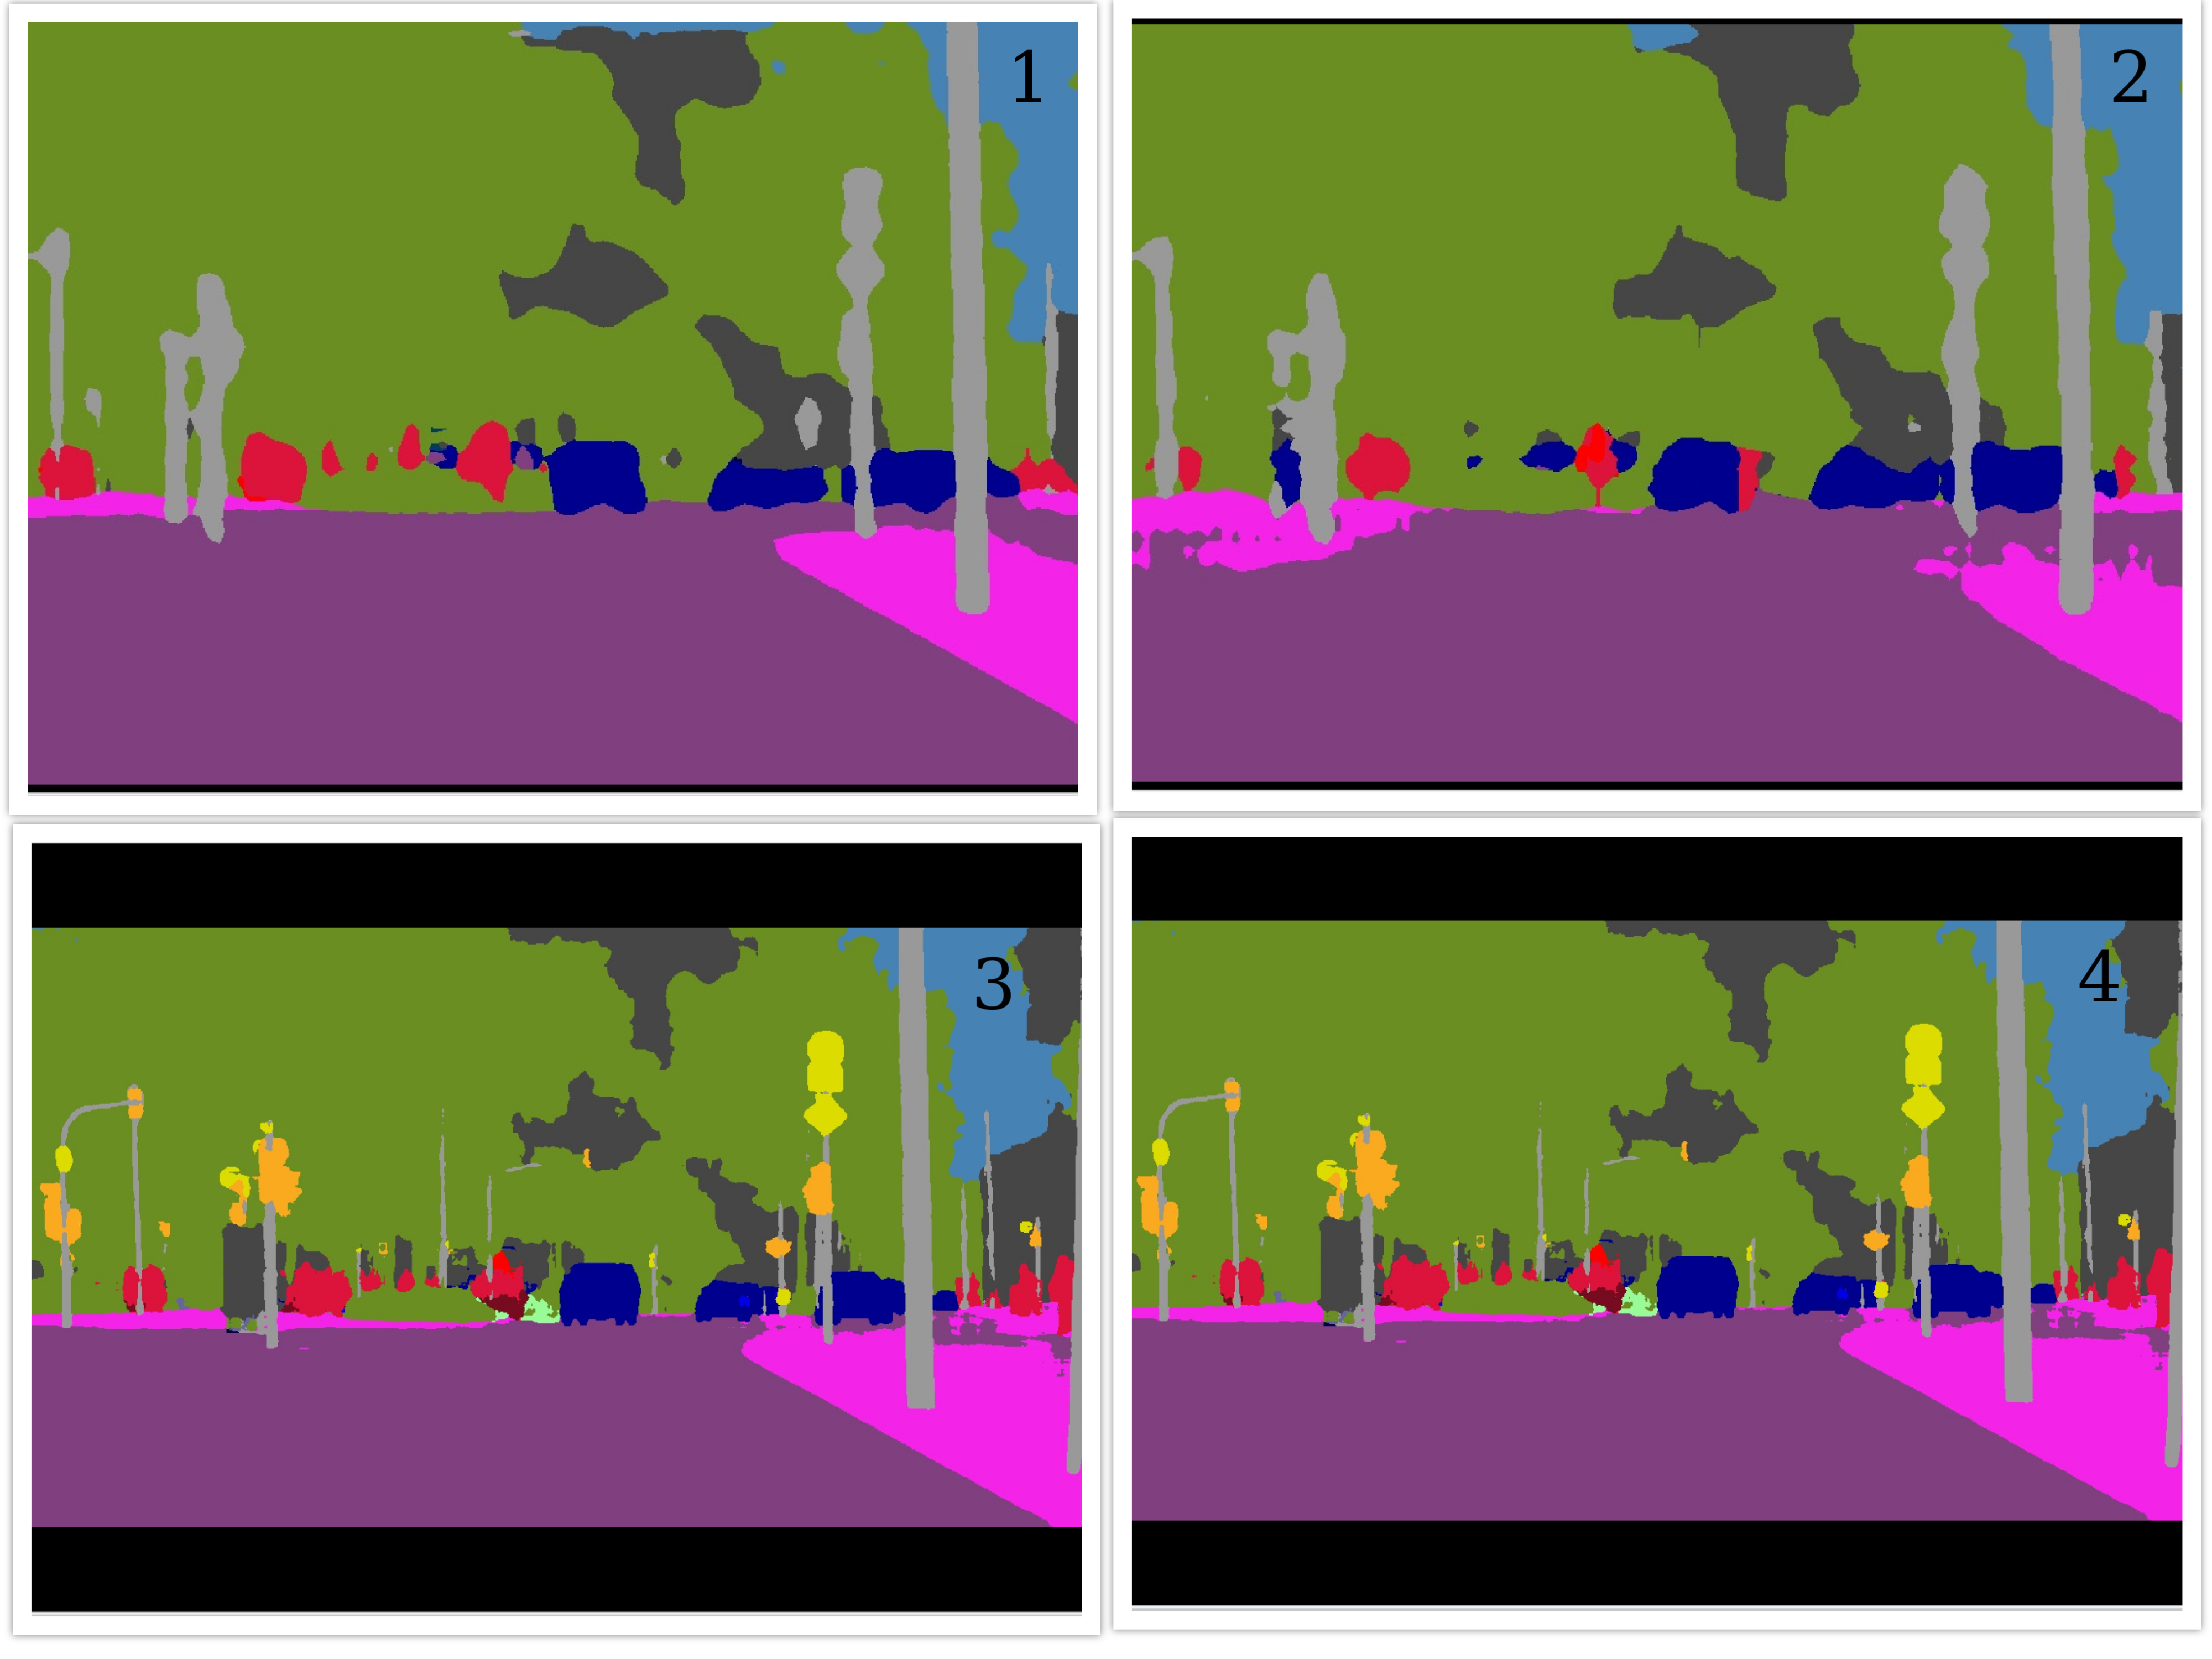

The images in fig. 1-4 are the Segmentation Inference outputs for the models respectively.

1. **mobilenet_v3_small_968_608_os8.pb**
2. **mobilenet_v3_large_968_608_os8.pb**
3. **mobilenetv3_large_os8_deeplabv3plus_72miou**
4. **best_weights_e=00231_val_loss=0**

where,  **`1. mobilenet_v3_small_968_608_os8.pb`** and **`2. mobilenet_v3_large_968_608_os8.pb`** are the TF Frozen Graph Models,

 while **`3. mobilenetv3_large_os8_deeplabv3plus_72miou`** and **`4. best_weights_e=00231_val_loss=0`** are the TF Saved Models

### Benchmarks Report

The Benchmarks for both TF Serving and the MQTT Based Inference performance were curated in a excel/csv table. 

Importing the benchmarks report in pandas to be able to explore the data interactively.

In [2]:
import pandas as pd

def load_csv_to_dataframe(path):
    """
    Reads a CSV file from the given path and returns it as a DataFrame.

    :param path: Path to the CSV file.
    :return: DataFrame containing the CSV content.
    """
    return pd.read_csv(path)

### Benchmarking Plots

**TF Serving Inference Benchmarking Data**

**Tensorflow Serving (REST + gRPC) x Localhost**

![tf_local.jpeg](assets/data/tf_local.jpeg)

**Tensorflow Serving (REST + gRPC) x IKA**

![tf_ika.jpeg](assets/data/tf_ika.jpeg)

**Tensorflow Serving (REST + gRPC) x Localhost**

![tf_local.jpeg](assets/data/tf_local.jpeg)

**MQTT Inference Benchmarking Data**

**MQTT Inference x Localhost**

**MQTT Inference x IKA**

![mqtt_ika.jpeg](assets/data/mqtt_ika.jpeg)

**MQTT Inference x Localhost**

![mqtt_local.jpeg](assets/data/mqtt_local.jpeg)

### Lessons Learnt

> Effective use of gitlab issues, dockers, port forwarding

> **gRPC vs REST**

1. **Definition**:
- **gRPC**: Originally developed by Google, gRPC is a high-performance, open-source framework that uses HTTP/2 for transport, Protocol Buffers as the interface description language, and it provides features such as authentication, load balancing, and more.
- **REST**: Representational State Transfer is an architectural style for distributed systems. It uses standard HTTP methods and status codes, URLs, and MIME types.

**Performance**:
- **HTTP/2 in gRPC**: gRPC uses HTTP/2 as its transport layer protocol. HTTP/2 is a significant enhancement over HTTP/1.1, especially in terms of performance. It provides features like multiplexing, which allows multiple requests and responses to be in flight at the same time, reducing latency.
- **Data Format**: gRPC uses Protocol Buffers (often called "protobuf"), which is a binary serialization format. This is generally more efficient in terms of both speed and size than the typical JSON or XML formats used in RESTful APIs.

**Latency**:
- Given the above performance and efficiency characteristics, gRPC is inherently more latency-optimized than REST. Your research showing gRPC being about 83% faster than REST in Tensorflow Serving is consistent with the efficiency gains that many developers observe when switching to gRPC, especially for intensive tasks like serving deep learning models.

**Use Case in Deep Learning**:
- **TensorFlow Serving**: TensorFlow Serving, which is designed to serve TensorFlow models, natively supports gRPC as a communication protocol. Given the potentially large size of data payloads (like images or videos) and the need for rapid responses in real-time applications, gRPC's performance gains are critical.

In conclusion, when it comes to deep learning segmentation models where latency is a crucial factor, gRPC's advantages in terms of its binary format, multiplexing capabilities, and efficient transport mechanism make it a strong contender against REST-based communication, as evidenced by its 83% faster performance in TensorFlow Serving.

# Conclusion

After analysing all the data and results, we oberved that,

> **gRPC is about 83% faster than REST based Communication.**

> **Prediction time is much faster in GPU than CPU**

> **Postprocessing takes almost &gt;90% time when it comes to MQTT based Serving with GPU as compared to CPU.**

> **TFServing is a better approach in terms of setting up and ease of use as compared to mqtt. However mqtt is faster in terms of inferencing due to lack of request processing**

## Future work

> Benchmark TFServing and MQTT-based serving across different system, simulating a vehicle-cloud interface over differing network conditions.

> Testing concurrency performance of these systems by making requests from multiple 'vehicle' nodes to one cloud node. 

> Test out nvidia triton server to compare performance with the Tensorflow Serving framework, evaluating the performance, ease of use and robustness.

## Acknowledgements

First and foremost, we would like to express our deepest gratitude to our esteemed professors, Lennart Reiher and Bastian Lampe, for granting us the invaluable opportunity to undertake this significant research project. Their unwavering support, guidance, and profound insights have been instrumental to the conceptualization and realization of our work.

Beyond their technical expertise, their dedication and patience in mentoring us have been a constant source of inspiration, pushing us to strive for excellence and to approach challenges with a discerning and analytical mindset. Their keen observations and constructive critiques have been pivotal in refining our ideas and ensuring the rigor of our methodologies.

Moreover, we appreciate the time they took from their demanding schedules to provide feedback, address our queries, and direct us towards pertinent resources. Their genuine interest in our professional and academic growth, coupled with their commitment to fostering a nurturing research environment, has greatly enriched our experience.

In culmination, we acknowledge that this project would not have reached its current stature without their guidance. 

We extend our sincere thanks and hope to uphold the standards they have set, in our future endeavors.

### Conclusion

*As the final building block of the report, the contents and results of the research should be summarized. The conclusion often also includes a short outlook on future research motivated through the one at hand.*

#### References

*The list of references lists further information about all work that has been cited. Please make sure to hyperlink all references.*

| # | Year | Authors | Title |
| --- | --- | --- | --- |
| 1 | 2023 | ika-rwth-aachen | [mqtt-in-docker github repository](https://github.com/ika-rwth-aachen/mqtt-in-docker) |
| 2 | 2017 | Christopher Olston and Fangwei Li and Jeremiah Harmsen and Jordan Soyke and Kiril Gorovoy and Li Lao and Noah Fiedel and Sukriti Ramesh and Vinu Rajashekhar | [TensorFlow-Serving: Flexible, High-Performance ML Serving](https://research.google/pubs/pub46801/) |

